# Cross-Country Quantile Forecasting with Factor Neural Networks

This notebook demonstrates a complete end-to-end workflow for multi-horizon quantile forecasting across countries using Factor Neural Networks (FNN) and Linear Quantile Regression (LQR).

## Overview

The workflow includes:
1. **Data Loading & Exploration**: Load country time series data and explore patterns
2. **Data Preprocessing**: Handle missing values, scaling, and create lagged features
3. **Model Training**: Train both Factor Neural Networks and Linear Quantile Regression
4. **Model Evaluation**: Compare models using quantile loss and Diebold-Mariano tests
5. **Visualization**: Create forecast plots, calibration diagrams, and factor analysis

## Key Features

- **Multi-country analysis** with cross-validation across countries
- **Multi-horizon forecasting** (1, 4, 8 periods ahead)
- **Quantile regression** for uncertainty quantification
- **Factor interpretation** from neural network last layers
- **Statistical testing** for model comparison

## 1. Import Required Libraries

Import essential libraries for data processing, modeling, and visualization.

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import yaml
from datetime import datetime


# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Project imports (adjust paths as needed)
import sys
sys.path.append('..')

from src.utils import (
    load_country_data, 
    load_config,
    set_seeds,
    handle_missing_values,
    scale_features,
    create_lagged_features,
    create_forecast_targets,
    create_time_split
)

# Import high-level API classes
from src.ensemble_nn_api import EnsembleNNAPI  # High-level API from ensemble_nn_api.py
from src.lqr_api import LQRModel        # High-level API from lqr_api.py

# Alternative: Low-level API (from the packages)

from src.metrics import (
    pinball_loss,
    compute_quantile_losses,
    create_loss_summary_table,
    dm_test_by_groups,
    multiple_testing_correction
)

from src.evaluation import (
    create_model_comparison_table,
    plot_training_curves,
    plot_forecast_paths,
    plot_loss_comparison,
    plot_calibration,
    create_evaluation_dashboard
)

import torch 
torch.set_num_threads(4) 


print("Libraries imported successfully!")
print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

# print(f"LQRModel class: {LQRModel}")

Error importing in API mode: ImportError("dlopen(/Users/siccokooiker/surfdrive/ml_macro_at_risk/.venv/lib/python3.13/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <B96A8100-FA7A-3EFC-8726-931D26646DE6> /Users/siccokooiker/surfdrive/ml_macro_at_risk/.venv/lib/python3.13/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.


Libraries imported successfully!
Numpy version: 2.3.2
Pandas version: 2.3.1


In [2]:
# Enable auto-reload for development
# This will automatically reload modules when you change the source code
%load_ext autoreload
%autoreload 2

# Optional: For more verbose reloading info
# %autoreload 1  # Only reload modules imported with %aimport
# %autoreload 0  # Disable autoreload

print("Auto-reload enabled: Changes to source files will be automatically reloaded!")

Auto-reload enabled: Changes to source files will be automatically reloaded!


## 2. Configuration and Setup

Load configuration and set up the experiment parameters.

In [3]:
# Load configuration
config_path = "../configs/experiment_big_data.yaml"

try:
    config = load_config(config_path)
    print("Configuration loaded successfully!")
    print("\nKey parameters:")
    print(f"Target variable: {config['data']['target']}")
    print(f"Quantiles: {config['data']['quantiles']}")
    print(f"Horizons: {config['data']['horizons']}")
    print(f"Lags: {config['data']['lags']}")
    print(f"Validation size: {config['splits']['validation_size']}")
except FileNotFoundError:
    print(f"Configuration file not found at {config_path}")
    print("Using default configuration...")
    
    # Default configuration
    config = {
        'seed': 123,
        'data': {
            'target': 'GDP',
            'required_columns': ['TIME', 'CISS', 'INFL_OECD', 'GDP', 'CREDIT_TO_GDP'],
            'quantiles': [0.05, 0.95],
            'horizons': [1],
            'lags': [1],
            'missing': 'forward_fill_then_mean',
            'scale': 'per_country',
            'scale_target': False
        },
        'splits': {
            'validation_size': 0.2,
            'train_start': '1990-12-31',
            'test_cutoff': '2018-12-31',
            'min_train_points': 60
        },
        'ensemble_nn': {
            'units_per_layer': [8, 4],
            'activation': 'relu',
            'optimizer': 'adam',
            'learning_rate': 1e-3,
            'epochs': 50,  # Reduced for demo
            'batch_size': 64,
            'patience': 10,
            'parallel_models': 1,  # Single model for demo
            'device': 'auto'
        },
        'lqr': {
            'alphas': [0.0, 0.1, 1.0, 10.0],
            'solver': 'huberized'
        }
    }

# Set random seed
set_seeds(config['seed'])
print(f"\nRandom seed set to: {config['seed']}")

Configuration loaded successfully!

Key parameters:
Target variable: prc_hicp_manr_CP00
Quantiles: [0.9]
Horizons: [1]
Lags: []
Validation size: 0.3

Random seed set to: 123


## 3. Load and Explore Dataset

Load country time series data and perform exploratory data analysis.

In [4]:
# Load country data
data_path = "../processed_per_country"

try:
    # Load all country CSV files
    country_data = load_country_data(
        data_path=data_path,
        required_columns=config['data']['required_columns']
    )
    
    print(f"Successfully loaded data for {len(country_data)} countries:")
    countries = list(country_data.keys())
    for country, df in country_data.items():

        print(f"  {country}: {len(df)} observations, {df['TIME'].min()} to {df['TIME'].max()}")
    
    # Display first few rows of a sample country
    sample_country = list(country_data.keys())[0]
    print(f"\nSample data from {sample_country}:")
    display(country_data[sample_country].head())
    
    # Summary statistics
    print(f"\nSummary statistics for {sample_country}:")
    display(country_data[sample_country].describe())
    
except FileNotFoundError:
    print(f"Data directory not found at {data_path}")
    print("Creating synthetic data for demonstration...")
    
    # Create synthetic data for demonstration
    countries = ['USA', 'DEU', 'FRA', 'GBR']
    start_date = '2000-01-01'
    end_date = '2023-12-31'
    freq = 'Q'  # Quarterly data
    
    country_data = {}
    np.random.seed(config['seed'])
    
    for country in countries:
        dates = pd.date_range(start_date, end_date, freq=freq)
        n_obs = len(dates)
        
        # Generate synthetic time series with trends and cycles
        t = np.arange(n_obs)
        trend = 0.01 * t + np.random.normal(0, 0.1, n_obs).cumsum()
        
        df = pd.DataFrame({
            'TIME': dates,
            'GDP': 100 + trend + np.random.normal(0, 2, n_obs),
            'CISS': np.random.beta(2, 5, n_obs),
            'INFL_OECD': np.random.normal(2, 1, n_obs),
            'CREDIT_TO_GDP': 150 + 10 * np.sin(t / 20) + np.random.normal(0, 5, n_obs)
        })
        
        country_data[country] = df
    
    print(f"Created synthetic data for {len(country_data)} countries")
    sample_country = countries[0]
    print(f"\nSample synthetic data from {sample_country}:")
    display(country_data[sample_country].head())

# manually put the columns names in the config
config['data']['required_columns'] = list(country_data[sample_country].columns)
print(f"\nUpdated required columns in config: {config['data']['required_columns']}")

Successfully loaded data for 24 countries:
  DK: 305 observations, 2000-02-01 00:00:00 to 2025-06-01 00:00:00
  HU: 305 observations, 2000-02-01 00:00:00 to 2025-06-01 00:00:00
  SE: 305 observations, 2000-02-01 00:00:00 to 2025-06-01 00:00:00
  IT: 305 observations, 2000-02-01 00:00:00 to 2025-06-01 00:00:00
  FR: 305 observations, 2000-02-01 00:00:00 to 2025-06-01 00:00:00
  PT: 305 observations, 2000-02-01 00:00:00 to 2025-06-01 00:00:00
  LV: 305 observations, 2000-02-01 00:00:00 to 2025-06-01 00:00:00
  DE: 305 observations, 2000-02-01 00:00:00 to 2025-06-01 00:00:00
  EE: 305 observations, 2000-02-01 00:00:00 to 2025-06-01 00:00:00
  NL: 305 observations, 2000-02-01 00:00:00 to 2025-06-01 00:00:00
  AT: 305 observations, 2000-02-01 00:00:00 to 2025-06-01 00:00:00
  EL: 305 observations, 2000-02-01 00:00:00 to 2025-06-01 00:00:00
  SK: 305 observations, 2000-02-01 00:00:00 to 2025-06-01 00:00:00
  CZ: 305 observations, 2000-02-01 00:00:00 to 2025-06-01 00:00:00
  PL: 305 observati

,TIME,ei_bsbu_m_r2_BS-CCI-BAL,ei_bsbu_m_r2_BS-CEME-BAL,ei_bsbu_m_r2_BS-COB-BAL,ei_bsbu_m_r2_BS-CPE-BAL,ei_bsbu_m_r2_BS-CTA-BAL,ei_bsbu_m_r2_BS-FLBA1-PC,ei_bsbu_m_r2_BS-FLBA2-PC,ei_bsbu_m_r2_BS-FLBA3-PC,ei_bsbu_m_r2_BS-FLBA4-PC,...,sts_trtu_m_G47_X_G473,une_rt_m_25_74_F,une_rt_m_25_74_M,une_rt_m_25_74_T,une_rt_m_lt25_F,une_rt_m_lt25_M,une_rt_m_lt25_T,une_rt_m_total_F,une_rt_m_total_M,une_rt_m_total_T
0,2000-02-01,-5.4,2.2,-13.1,-10.5,6.5,74.9,9.9,4.3,9.1,...,0.013483,-0.080043,-0.077962,-0.090972,0.004969,-0.000360,-0.139113,-0.117783,-0.065958,-0.083382
1,2000-03-01,-3.9,0.0,-7.9,-12.3,13.8,77.9,9.9,3.7,7.9,...,-0.018668,-0.064539,-0.027399,-0.024098,-0.013780,-0.010702,-0.045810,-0.042560,-0.046520,-0.044452
2,2000-04-01,-10.3,-4.8,-15.7,-11.4,8.5,79.7,7.7,4.5,9.1,...,0.009699,0.000000,0.000000,-0.024693,0.011133,-0.024705,0.000000,0.021506,-0.024098,0.000000
3,2000-05-01,-12.2,-5.8,-18.5,-18.4,-0.1,75.3,8.0,5.4,9.7,...,0.007054,0.043485,0.000000,0.024693,-0.009784,-0.011419,0.015504,0.041673,0.000000,0.022473
4,2000-06-01,-9.7,-1.3,-18.1,-15.6,-6.4,74.7,8.8,5.3,10.2,...,0.000000,-0.021506,-0.057158,-0.024693,0.004011,-0.007115,0.000000,0.000000,-0.050010,-0.022473



Summary statistics for DK:


,TIME,ei_bsbu_m_r2_BS-CCI-BAL,ei_bsbu_m_r2_BS-CEME-BAL,ei_bsbu_m_r2_BS-COB-BAL,ei_bsbu_m_r2_BS-CPE-BAL,ei_bsbu_m_r2_BS-CTA-BAL,ei_bsbu_m_r2_BS-FLBA1-PC,ei_bsbu_m_r2_BS-FLBA2-PC,ei_bsbu_m_r2_BS-FLBA3-PC,ei_bsbu_m_r2_BS-FLBA4-PC,...,sts_trtu_m_G47_X_G473,une_rt_m_25_74_F,une_rt_m_25_74_M,une_rt_m_25_74_T,une_rt_m_lt25_F,une_rt_m_lt25_M,une_rt_m_lt25_T,une_rt_m_total_F,une_rt_m_total_M,une_rt_m_total_T
count,305,305.000000,305.000000,305.00000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,...,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000
mean,2012-09-30 15:01:46.229508096,-14.045902,-3.076721,-25.01377,-11.299344,-2.499672,57.721967,19.869508,5.960656,16.004918,...,0.000966,0.000000,0.000665,0.000273,-0.000486,-0.000115,0.002208,0.000505,0.001306,0.000960
min,2000-02-01 00:00:00,-55.400000,-36.900000,-79.60000,-54.200000,-43.300000,4.200000,1.300000,-2.700000,-2.800000,...,-0.116327,-0.494696,-0.485508,-0.327213,-0.113876,-0.096818,-0.519578,-0.378436,-0.367725,-0.263815
25%,2006-06-01 00:00:00,-22.300000,-10.000000,-34.60000,-17.700000,-8.500000,51.100000,14.300000,3.800000,4.000000,...,-0.007621,-0.080043,-0.077962,-0.047628,-0.017727,-0.014368,-0.063013,-0.059423,-0.058841,-0.039221
50%,2012-10-01 00:00:00,-11.900000,-1.800000,-20.20000,-9.200000,-0.700000,58.000000,20.200000,5.200000,13.300000,...,0.001496,0.000000,0.000000,0.000000,-0.001668,-0.000291,0.000000,0.000000,0.000000,0.000000
75%,2019-02-01 00:00:00,-4.300000,5.300000,-13.80000,-4.000000,5.900000,67.200000,25.400000,6.700000,27.100000,...,0.009699,0.061875,0.077962,0.050010,0.014145,0.014473,0.068993,0.052644,0.061875,0.033902
max,2025-06-01 00:00:00,16.200000,16.900000,17.30000,9.500000,20.000000,79.700000,40.700000,34.300000,50.100000,...,0.168522,0.395896,0.470004,0.340927,0.115066,0.162396,0.493281,0.374693,0.413187,0.271934
std,NaN,14.324186,10.702488,19.26683,11.047731,12.211644,11.981639,8.412820,4.026503,12.752472,...,0.021256,0.136770,0.145165,0.092021,0.027542,0.028586,0.139008,0.114723,0.119745,0.079207



Updated required columns in config: ['TIME', 'ei_bsbu_m_r2_BS-CCI-BAL', 'ei_bsbu_m_r2_BS-CEME-BAL', 'ei_bsbu_m_r2_BS-COB-BAL', 'ei_bsbu_m_r2_BS-CPE-BAL', 'ei_bsbu_m_r2_BS-CTA-BAL', 'ei_bsbu_m_r2_BS-FLBA1-PC', 'ei_bsbu_m_r2_BS-FLBA2-PC', 'ei_bsbu_m_r2_BS-FLBA3-PC', 'ei_bsbu_m_r2_BS-FLBA4-PC', 'ei_bsbu_m_r2_BS-FLBA5-PC', 'ei_bsbu_m_r2_BS-FLBA6-PC', 'ei_bsbu_m_r2_BS-FLBA7-PC', 'ei_bsco_m_BS-CSMCI', 'ei_bsco_m_BS-FS-LY', 'ei_bsco_m_BS-FS-NY', 'ei_bsco_m_BS-GES-LY', 'ei_bsco_m_BS-GES-NY', 'ei_bsco_m_BS-MP-NY', 'ei_bsco_m_BS-MP-PR', 'ei_bsco_m_BS-PT-LY', 'ei_bsco_m_BS-PT-NY', 'ei_bsco_m_BS-SFSH', 'ei_bsco_m_BS-SV-NY', 'ei_bsco_m_BS-UE-NY', 'ei_bsee_m_r2_BS-CEME-BAL', 'ei_bsee_m_r2_BS-EEI-I', 'ei_bsee_m_r2_BS-IEME-BAL', 'ei_bsee_m_r2_BS-REM-BAL', 'ei_bsee_m_r2_BS-SEEM-BAL', 'ei_bsin_m_r2_BS-ICI', 'ei_bsin_m_r2_BS-IEME-BAL', 'ei_bsin_m_r2_BS-IEOB', 'ei_bsin_m_r2_BS-IOB', 'ei_bsin_m_r2_BS-IPE', 'ei_bsin_m_r2_BS-IPT', 'ei_bsin_m_r2_BS-ISFP', 'ei_bsin_m_r2_BS-ISPE', 'ei_bslh_m_r2_BS-CLHI', 'ei_b

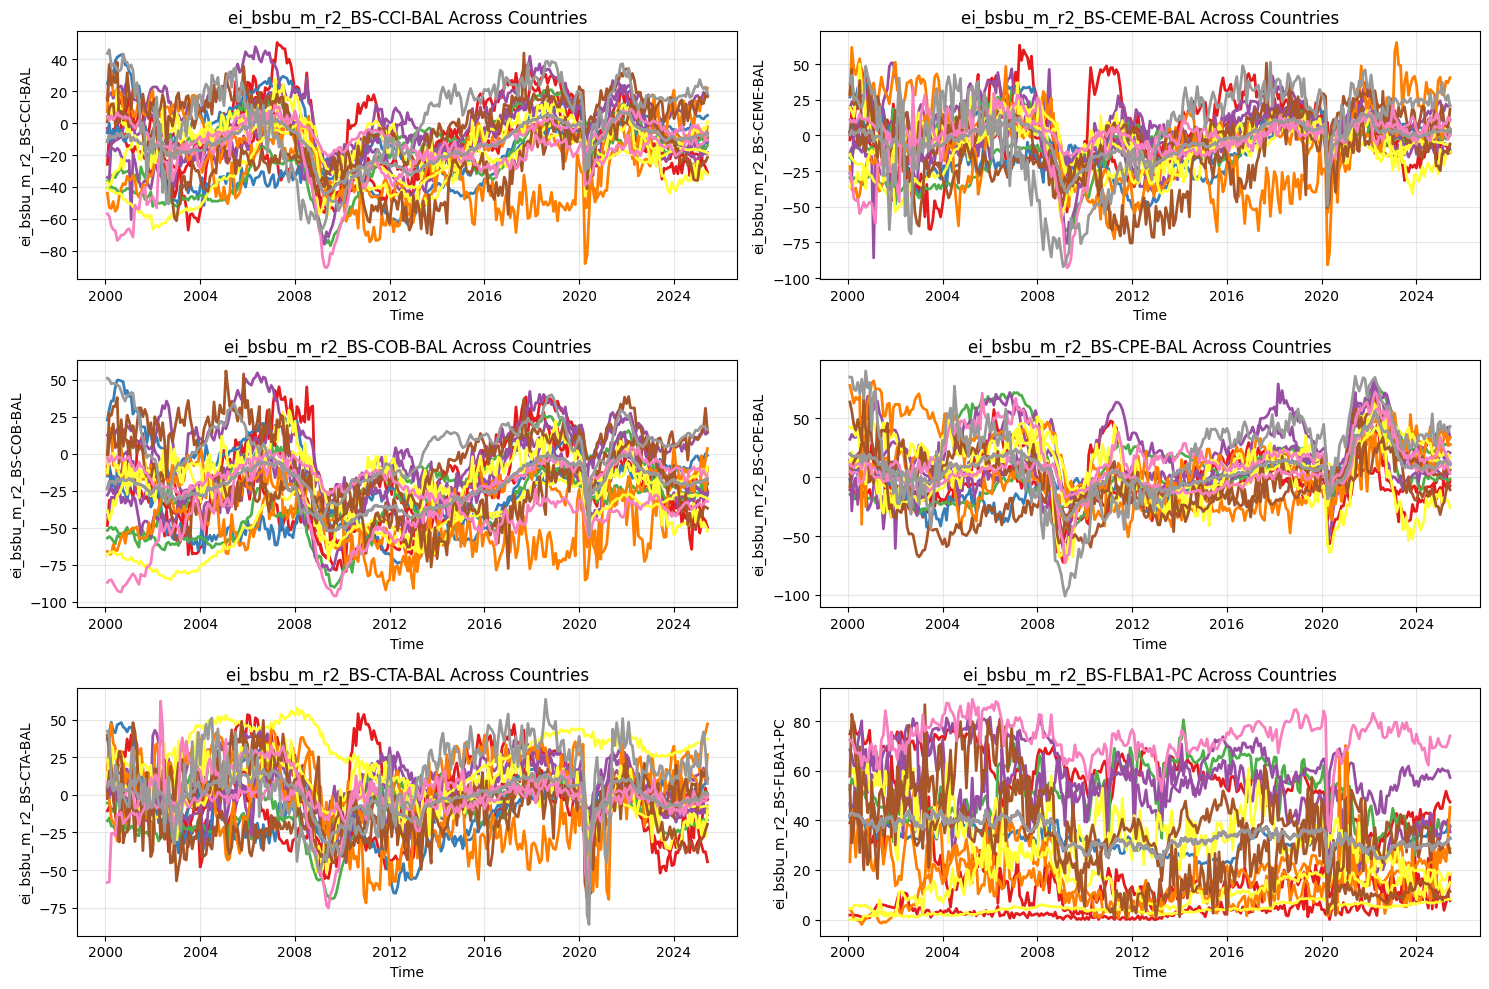


Correlation analysis:

DK - Correlation matrix:


,ei_bsbu_m_r2_BS-CCI-BAL,ei_bsbu_m_r2_BS-CEME-BAL,ei_bsbu_m_r2_BS-COB-BAL,ei_bsbu_m_r2_BS-CPE-BAL,ei_bsbu_m_r2_BS-CTA-BAL,ei_bsbu_m_r2_BS-FLBA1-PC,ei_bsbu_m_r2_BS-FLBA2-PC,ei_bsbu_m_r2_BS-FLBA3-PC,ei_bsbu_m_r2_BS-FLBA4-PC,ei_bsbu_m_r2_BS-FLBA5-PC,...,sts_trtu_m_G47_X_G473,une_rt_m_25_74_F,une_rt_m_25_74_M,une_rt_m_25_74_T,une_rt_m_lt25_F,une_rt_m_lt25_M,une_rt_m_lt25_T,une_rt_m_total_F,une_rt_m_total_M,une_rt_m_total_T
ei_bsbu_m_r2_BS-CCI-BAL,1.000,0.920,0.976,0.895,0.890,-0.235,-0.797,0.094,0.745,0.297,...,0.008,-0.087,-0.087,-0.138,-0.279,-0.276,-0.052,-0.088,-0.091,-0.132
ei_bsbu_m_r2_BS-CEME-BAL,0.920,1.000,0.812,0.907,0.889,-0.228,-0.622,0.159,0.616,0.163,...,-0.005,-0.089,-0.103,-0.155,-0.329,-0.357,-0.053,-0.094,-0.100,-0.144
ei_bsbu_m_r2_BS-COB-BAL,0.976,0.812,1.000,0.827,0.830,-0.222,-0.840,0.052,0.765,0.352,...,0.016,-0.080,-0.072,-0.118,-0.233,-0.212,-0.049,-0.079,-0.079,-0.116
ei_bsbu_m_r2_BS-CPE-BAL,0.895,0.907,0.827,1.000,0.856,-0.381,-0.564,0.141,0.706,0.383,...,-0.018,-0.096,-0.097,-0.154,-0.315,-0.345,-0.052,-0.093,-0.097,-0.142
ei_bsbu_m_r2_BS-CTA-BAL,0.890,0.889,0.830,0.856,1.000,-0.072,-0.686,-0.015,0.518,0.148,...,-0.000,-0.099,-0.104,-0.158,-0.307,-0.288,-0.070,-0.094,-0.121,-0.160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
une_rt_m_lt25_M,-0.276,-0.357,-0.212,-0.345,-0.288,0.062,0.151,-0.117,-0.170,-0.077,...,0.002,0.064,0.036,0.089,0.340,1.000,0.016,0.053,0.037,0.077
une_rt_m_lt25_T,-0.052,-0.053,-0.049,-0.052,-0.070,-0.017,0.069,0.031,-0.025,-0.017,...,0.175,0.074,-0.024,0.053,0.174,0.016,1.000,0.468,0.316,0.588
une_rt_m_total_F,-0.088,-0.094,-0.079,-0.093,-0.094,-0.031,0.086,0.000,-0.047,-0.018,...,0.047,0.829,-0.198,0.442,0.218,0.053,0.468,1.000,-0.107,0.611
une_rt_m_total_M,-0.091,-0.100,-0.079,-0.097,-0.121,-0.020,0.067,-0.011,-0.032,-0.013,...,0.049,-0.063,0.878,0.654,0.077,0.037,0.316,-0.107,1.000,0.709



DK - Last 10 columns:
Index(['sts_trtu_m_G47_X_G473', 'une_rt_m_25_74_F', 'une_rt_m_25_74_M',
       'une_rt_m_25_74_T', 'une_rt_m_lt25_F', 'une_rt_m_lt25_M',
       'une_rt_m_lt25_T', 'une_rt_m_total_F', 'une_rt_m_total_M',
       'une_rt_m_total_T'],
      dtype='object')

HU - Correlation matrix:


,ei_bsbu_m_r2_BS-CCI-BAL,ei_bsbu_m_r2_BS-CEME-BAL,ei_bsbu_m_r2_BS-COB-BAL,ei_bsbu_m_r2_BS-CPE-BAL,ei_bsbu_m_r2_BS-CTA-BAL,ei_bsbu_m_r2_BS-FLBA1-PC,ei_bsbu_m_r2_BS-FLBA2-PC,ei_bsbu_m_r2_BS-FLBA3-PC,ei_bsbu_m_r2_BS-FLBA4-PC,ei_bsbu_m_r2_BS-FLBA5-PC,...,sts_trtu_m_G47_X_G473,une_rt_m_25_74_F,une_rt_m_25_74_M,une_rt_m_25_74_T,une_rt_m_lt25_F,une_rt_m_lt25_M,une_rt_m_lt25_T,une_rt_m_total_F,une_rt_m_total_M,une_rt_m_total_T
ei_bsbu_m_r2_BS-CCI-BAL,1.000,0.960,0.988,0.491,0.897,0.390,-0.885,0.193,0.780,0.760,...,0.163,-0.111,-0.158,-0.148,-0.067,-0.047,-0.070,-0.120,-0.162,-0.154
ei_bsbu_m_r2_BS-CEME-BAL,0.960,1.000,0.904,0.481,0.814,0.421,-0.787,0.208,0.709,0.665,...,0.131,-0.077,-0.141,-0.123,-0.037,-0.047,-0.053,-0.080,-0.153,-0.127
ei_bsbu_m_r2_BS-COB-BAL,0.988,0.904,1.000,0.479,0.912,0.360,-0.908,0.177,0.793,0.787,...,0.175,-0.126,-0.162,-0.156,-0.081,-0.046,-0.077,-0.138,-0.161,-0.163
ei_bsbu_m_r2_BS-CPE-BAL,0.491,0.481,0.479,1.000,0.389,0.335,-0.529,0.164,0.432,0.525,...,0.136,-0.080,-0.094,-0.098,-0.097,-0.060,-0.095,-0.102,-0.107,-0.113
ei_bsbu_m_r2_BS-CTA-BAL,0.897,0.814,0.912,0.389,1.000,0.154,-0.777,0.126,0.593,0.637,...,0.159,-0.182,-0.241,-0.238,-0.121,-0.104,-0.136,-0.199,-0.258,-0.251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
une_rt_m_lt25_M,-0.047,-0.047,-0.046,-0.060,-0.104,-0.033,0.033,0.014,-0.036,0.013,...,-0.090,0.217,0.292,0.301,0.375,1.000,0.866,0.309,0.584,0.480
une_rt_m_lt25_T,-0.070,-0.053,-0.077,-0.095,-0.136,-0.028,0.070,0.009,-0.059,-0.026,...,-0.173,0.277,0.373,0.386,0.782,0.866,1.000,0.464,0.626,0.592
une_rt_m_total_F,-0.120,-0.080,-0.138,-0.102,-0.199,0.010,0.110,-0.013,-0.116,-0.067,...,-0.241,0.906,0.599,0.841,0.456,0.309,0.464,1.000,0.617,0.850
une_rt_m_total_M,-0.162,-0.153,-0.161,-0.107,-0.258,-0.024,0.104,-0.033,-0.107,-0.039,...,-0.302,0.557,0.853,0.795,0.435,0.584,0.626,0.617,1.000,0.861



HU - Last 10 columns:
Index(['sts_trtu_m_G47_X_G473', 'une_rt_m_25_74_F', 'une_rt_m_25_74_M',
       'une_rt_m_25_74_T', 'une_rt_m_lt25_F', 'une_rt_m_lt25_M',
       'une_rt_m_lt25_T', 'une_rt_m_total_F', 'une_rt_m_total_M',
       'une_rt_m_total_T'],
      dtype='object')


In [5]:
# Visualize the data
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()

variables = config['data']['required_columns'][1:]  # Exclude 'TIME'
colors = plt.cm.Set1(np.linspace(0, 1, len(country_data)))

for i, var in enumerate(variables[:6]):
    ax = axes[i]
    
    for j, (country, df) in enumerate(country_data.items()):
        ax.plot(df['TIME'], df[var], label=country, color=colors[j], linewidth=2)
    
    ax.set_title(f'{var} Across Countries')
    ax.set_xlabel('Time')
    ax.set_ylabel(var)
    #ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation analysis
print("\nCorrelation analysis:")
for country, df in list(country_data.items())[:2]:  # Show first 2 countries
    print(f"\n{country} - Correlation matrix:")
    corr_matrix = df[variables].corr()
    display(corr_matrix.round(3))

# print names of last 10 columns
    print(f"\n{country} - Last 10 columns:")
    print(df.columns[-10:])

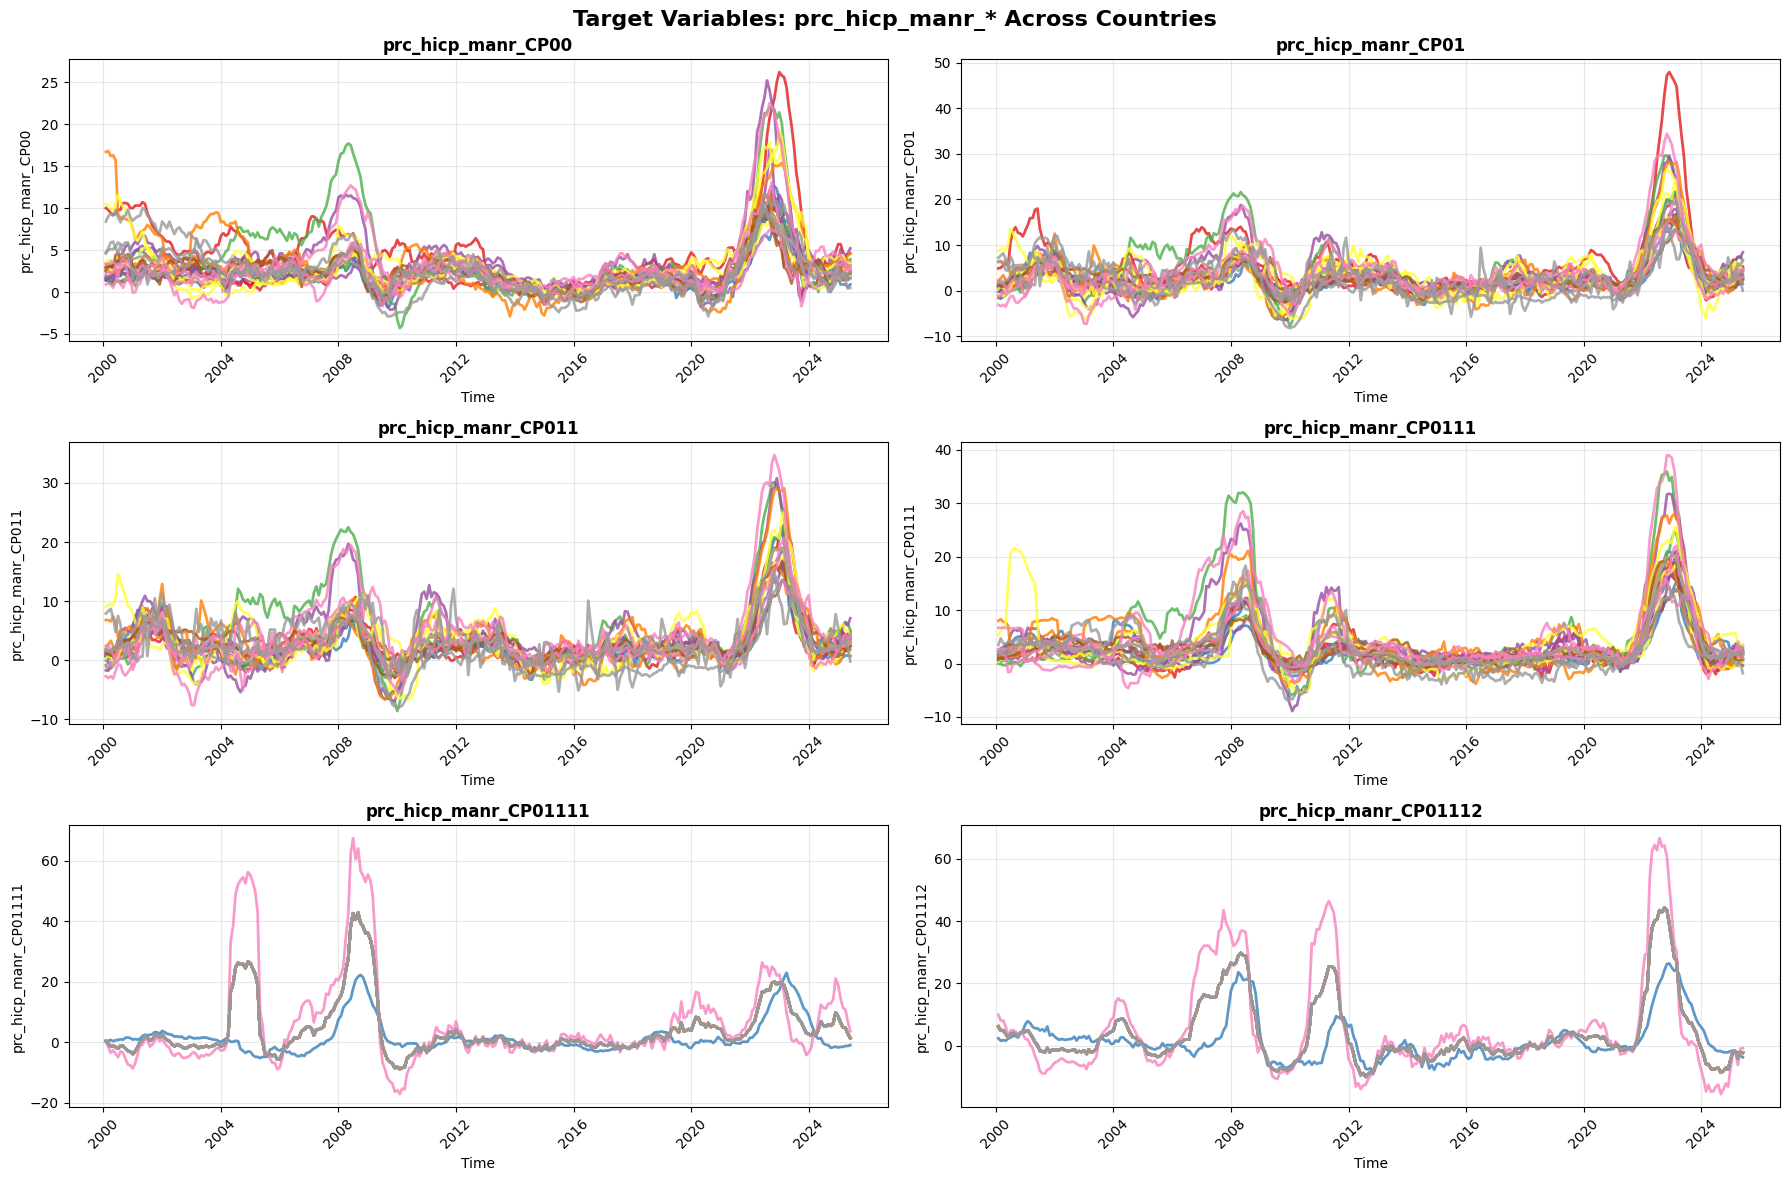

Plotted 6 target variables with prefix 'prc_hicp_manr_'


In [6]:
# Plot variables that start with the target prefix in a nice panel layout
colors = plt.cm.Set1(np.linspace(0, 1, len(country_data)))
target_prefix = config['data']['target'].rsplit('_', 1)[0] + '_'
target_vars = [col for col in country_data[sample_country].columns if col.startswith(target_prefix)]

# Create a panel layout (2x3 for 6 variables)
n_vars_to_plot = min(6, len(target_vars))
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
axes = axes.flatten()

for i, var in enumerate(target_vars[:n_vars_to_plot]):
    ax = axes[i]
    
    for j, (country, df) in enumerate(country_data.items()):
        ax.plot(df['TIME'], df[var], label=country, color=colors[j], linewidth=2, alpha=0.8)
    
    ax.set_title(f'{var}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Time')
    ax.set_ylabel(var)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
   
# Hide empty subplots if we have fewer than 6 variables
for i in range(n_vars_to_plot, 6):
    axes[i].set_visible(False)

plt.suptitle(f'Target Variables: {target_prefix}* Across Countries', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Plotted {n_vars_to_plot} target variables with prefix '{target_prefix}'")

## 4. Data Preprocessing

Handle missing values, scaling, and create time splits.

In [7]:
# 1. Handle missing values
print("Handling missing values...")
processed_data = handle_missing_values(
    country_data, 
    policy=config['data']['missing']
)

# Check for missing values
print("\nMissing values after processing:")
for country, df in processed_data.items():
    missing_count = df.isnull().sum().sum()
    print(f"{country}: {missing_count} missing values")

# 2. Create time splits
print("\nCreating time splits...")
train_data, test_data, dropped_countries = create_time_split(
    processed_data,
    train_start=config['splits']['train_start'],
    test_cutoff=config['splits']['test_cutoff'],
    min_train_points=config['splits']['min_train_points']
)

print(f"Train/test split created:")
print(f"  Training countries: {len(train_data)}")
print(f"  Test countries: {len(test_data)}")
print(f"  Dropped countries: {dropped_countries}")

# Show split sizes
for country in list(train_data.keys())[:3]:  # First 3 countries
    train_size = len(train_data[country])
    test_size = len(test_data[country])
    print(f"  {country}: {train_size} train, {test_size} test")

# 3. Scale features (on training data)
print("\nScaling features...")
scaled_train, scaled_test, scalers = scale_features(
    train_data=train_data,
    test_data=test_data,
    policy=config['data']['scale'],
    target_col=config['data']['target'],
    scale_target=config['data']['scale_target'],
    trimming=config['data']['trimming'],  # Optional trimming parameter
)

print(f"Feature scaling completed using '{config['data']['scale']}' policy")

Handling missing values...

Missing values after processing:
DK: 0 missing values
HU: 0 missing values
SE: 0 missing values
IT: 0 missing values
FR: 0 missing values
PT: 0 missing values
LV: 0 missing values
DE: 0 missing values
EE: 0 missing values
NL: 0 missing values
AT: 0 missing values
EL: 0 missing values
SK: 0 missing values
CZ: 0 missing values
PL: 0 missing values
FI: 0 missing values
LU: 0 missing values
ES: 0 missing values
LT: 0 missing values
MT: 0 missing values
BE: 0 missing values
IE: 0 missing values
SI: 0 missing values
CY: 0 missing values

Creating time splits...
Train/test split created:
  Training countries: 24
  Test countries: 24
  Dropped countries: []
  DK: 140 train, 114 test
  HU: 140 train, 114 test
  SE: 140 train, 114 test

Scaling features...
DK
HU
SE
IT
FR
PT
LV
DE
EE
NL
AT
EL
SK
CZ
PL
FI
LU
ES
LT
MT
BE
IE
SI
CY
Feature scaling completed using 'per_country' policy


## 5. Feature Engineering

Create lagged features and forecast targets for multi-horizon prediction.

In [8]:
# 1. Create lagged features
print("Creating lagged features...")
lagged_train = create_lagged_features(
    scaled_train, 
    lags=config['data']['lags']
)

lagged_test = create_lagged_features(
    scaled_test, 
    lags=config['data']['lags']
)

# Show example of lagged features
sample_country = list(lagged_train.keys())[0]
print(f"\nLagged features for {sample_country}:")
print(f"Original columns: {list(scaled_train[sample_country].columns)}")
print(f"With lags: {list(lagged_train[sample_country].columns)}")
print(f"Data shape: {lagged_train[sample_country].shape}")

# 2. Create forecast targets
print("\nCreating forecast targets...")
target_train = create_forecast_targets(
    lagged_train,
    target_col=config['data']['target'],
    horizons=config['data']['horizons']
)

target_test = create_forecast_targets(
    lagged_test,
    target_col=config['data']['target'],
    horizons=config['data']['horizons']
)

# Show target structure
target_cols = [f"{config['data']['target']}_h{h}" for h in config['data']['horizons']]
print(f"Target columns: {target_cols}")

for country in list(target_train.keys())[:2]:
    print(f"{country} training shape: {target_train[country].shape}")
    print(f"{country} test shape: {target_test[country].shape}")

# Display sample of processed data
print(f"\nProcessed data sample from {sample_country}:")
display(target_train[sample_country][['TIME'] + target_cols].head())

Creating lagged features...

Lagged features for DK:
Original columns: ['TIME', 'ei_bsbu_m_r2_BS-CCI-BAL', 'ei_bsbu_m_r2_BS-CEME-BAL', 'ei_bsbu_m_r2_BS-COB-BAL', 'ei_bsbu_m_r2_BS-CPE-BAL', 'ei_bsbu_m_r2_BS-CTA-BAL', 'ei_bsbu_m_r2_BS-FLBA1-PC', 'ei_bsbu_m_r2_BS-FLBA2-PC', 'ei_bsbu_m_r2_BS-FLBA3-PC', 'ei_bsbu_m_r2_BS-FLBA4-PC', 'ei_bsbu_m_r2_BS-FLBA5-PC', 'ei_bsbu_m_r2_BS-FLBA6-PC', 'ei_bsbu_m_r2_BS-FLBA7-PC', 'ei_bsco_m_BS-CSMCI', 'ei_bsco_m_BS-FS-LY', 'ei_bsco_m_BS-FS-NY', 'ei_bsco_m_BS-GES-LY', 'ei_bsco_m_BS-GES-NY', 'ei_bsco_m_BS-MP-NY', 'ei_bsco_m_BS-MP-PR', 'ei_bsco_m_BS-PT-LY', 'ei_bsco_m_BS-PT-NY', 'ei_bsco_m_BS-SFSH', 'ei_bsco_m_BS-SV-NY', 'ei_bsco_m_BS-UE-NY', 'ei_bsee_m_r2_BS-CEME-BAL', 'ei_bsee_m_r2_BS-EEI-I', 'ei_bsee_m_r2_BS-IEME-BAL', 'ei_bsee_m_r2_BS-REM-BAL', 'ei_bsee_m_r2_BS-SEEM-BAL', 'ei_bsin_m_r2_BS-ICI', 'ei_bsin_m_r2_BS-IEME-BAL', 'ei_bsin_m_r2_BS-IEOB', 'ei_bsin_m_r2_BS-IOB', 'ei_bsin_m_r2_BS-IPE', 'ei_bsin_m_r2_BS-IPT', 'ei_bsin_m_r2_BS-ISFP', 'ei_bsin_m_r2_BS-IS

,TIME,prc_hicp_manr_CP00_h1
51,2004-05-01,1.0
52,2004-06-01,1.2
53,2004-07-01,0.8
54,2004-08-01,0.8
55,2004-09-01,1.6


## 6. Model Training

Train both Factor Neural Networks and Linear Quantile Regression with cross-validation.

In [9]:
def create_dummy_variables(data_list, time_col="TIME", add_country_dummies=False):
    # for each country in the data list add a country encoding variable 
    num_of_countries = len(data_list)
    if not add_country_dummies:
        return data_list
    
    new_data_list = []

    for i,  df in enumerate(data_list):
        df_copy = df.copy()
        for j in range(num_of_countries):
            dummy_col = f'dummy-{j}'
            if i != j:
                df_copy[dummy_col] = 0
            else:
                df_copy[dummy_col] = 1
        new_data_list.append(df_copy)
        
    # for i, df in enumerate(data_list):
    #     df_copy = df.copy()
    #     # Use simple integer encoding instead of one-hot dummies
    #     df_copy['country_id'] = i
    #     new_data_list.append(df_copy)


    
    return new_data_list


In [10]:
# Prepare data for models
# Convert country dictionaries to lists for model APIs
import traceback
from src.ensemble_nn_api import EnsembleNNAPI  # High-level API from ensemble_nn_api.py
from src.lqr_api import LQRModel        # High-level API from lqr_api.py

train_data_list = []
test_data_list = []

for country, df in scaled_train.items():
    df_copy = df.copy()
    #df_copy['country'] = country
    train_data_list.append(df_copy)

for country, df in scaled_test.items():
    df_copy = df.copy()
    #df_copy['country'] = country
    test_data_list.append(df_copy)

print(f"Prepared data for {len(train_data_list)} countries")

# Ensure all data types are proper (TIME should be datetime, others numeric)
for i, df in enumerate(train_data_list):
    if 'TIME' in df.columns and df['TIME'].dtype == 'object':
        train_data_list[i]['TIME'] = pd.to_datetime(df['TIME'])
            
for i, df in enumerate(test_data_list):
    if 'TIME' in df.columns and df['TIME'].dtype == 'object':
        test_data_list[i]['TIME'] = pd.to_datetime(df['TIME'])


if config['ensemble_nn']['country_dummies'] and not config['ensemble_nn']['per_country']:
    global_train_data_list = create_dummy_variables(
        train_data_list,
        time_col="TIME",
        add_country_dummies=config['ensemble_nn']['country_dummies']
    )
    
    global_test_data_list = create_dummy_variables(
        test_data_list,
        time_col="TIME",
        add_country_dummies=config['ensemble_nn']['country_dummies']
    )
else:
    global_train_data_list = train_data_list
    global_test_data_list = test_data_list



Prepared data for 24 countries



Training Factor Neural Network
Available countries: 24
✓ Ensemble NN initialized successfully!
  Input dimension: 1473
  Target quantiles: [0.9]
  Forecast horizons: [1]

Starting training with cross-validation...


Training:   0%|          | 0/2 [00:00<?, ?it/s]W0919 11:39:14.164000 21662 torch/_dynamo/exc.py:525] [1/0] Backend compiler exception
W0919 11:39:14.164000 21662 torch/_dynamo/exc.py:525] [1/0]   Explanation: Backend compiler `inductor` failed with aten._local_scalar_dense.default
W0919 11:39:14.164000 21662 torch/_dynamo/exc.py:525] [1/0] 
W0919 11:39:14.164000 21662 torch/_dynamo/exc.py:525] [1/0]     While executing %wrapped_getitem : [num_users=1] = call_function[target=torch._dynamo.utils.wrapped_getitem](args = (%l_self_features, %l_idx_), kwargs = {})
W0919 11:39:14.164000 21662 torch/_dynamo/exc.py:525] [1/0]     GraphModule: class GraphModule(torch.nn.Module):
W0919 11:39:14.164000 21662 torch/_dynamo/exc.py:525] [1/0]         def forward(self, L_self_features: "f64[3336, 1473][1, 3336]", L_idx_: "i64[][]", L_self_targets: "f64[3336, 1, 1][1, 1, 1]", L_self_countries: "i64[3336, 1, 1][1, 1, 1]"):
W0919 11:39:14.164000 21662 torch/_dynamo/exc.py:525] [1/0]             l_self_fe


✓ Ensemble NN training completed successfully!
  Results keys: ['history', 'n_parameters', 'validation_size', 'n_train_samples', 'n_val_samples', 'train_losses', 'val_losses', 'final_val_loss']
  Number of parameters: 517700
  Final validation loss: 0.03731738030910492


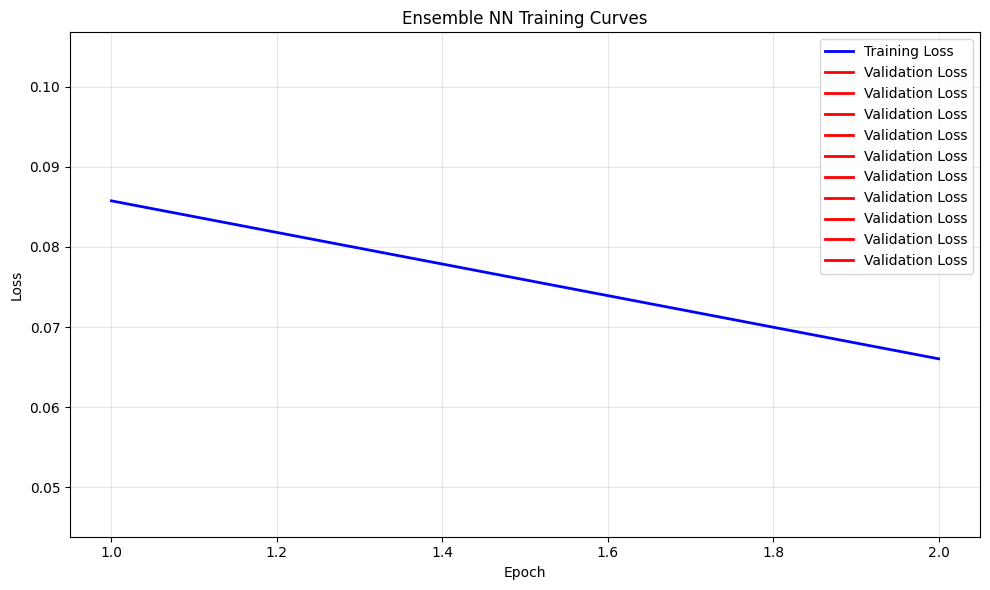


TRAINING STATUS SUMMARY
✓ Data preprocessing: SUCCESSFUL
✓ Feature engineering: SUCCESSFUL
✓ Dataset creation: SUCCESSFUL
✓ Data type handling: SUCCESSFUL (fixed object dtype issue)
✓ Factor NN training: SUCCESSFUL


In [11]:


# === Train Factor Neural Network ===
print("\n" + "="*50)
print("Training Factor Neural Network")
print("="*50)

# Determine optimal k_folds based on available countries

n_countries = len(train_data_list)

print(f"Available countries: {n_countries}")

country_names = [country for country in list(target_train.keys())]

if config['ensemble_nn']['per_country']:
    fnn_models = {}
    for i, df in enumerate(train_data_list):
       
        print(f"Training Factor NN for {i}...")

        ensemble_nn = EnsembleNNAPI(
            data_list=[df],
            target=config['data']['target'],
            quantiles=config['data']['quantiles'],
            forecast_horizons=config['data']['horizons'],
            units_per_layer=config['ensemble_nn']['units_per_layer'],
            lags=config['data']['lags'],
            activation=config['ensemble_nn']['activation'],
            device=config['ensemble_nn']['device'],
            seed=config['seed'], 
            transform=True,  # Enable data transformation
            turn_on_neural_net=config['ensemble_nn']['turn_on_neural_net']
        )
    
        ensemble_results = ensemble_nn.fit(
            epochs=config['ensemble_nn']['epochs'],
            learning_rate=config['ensemble_nn']['learning_rate'],
            batch_size=config['ensemble_nn']['batch_size'],
            validation_size=config['splits']['validation_size'],  # Use adjusted k_folds
            patience=config['ensemble_nn']['patience'],
            verbose=1,
            optimizer=config['ensemble_nn']['optimizer'],
            parallel_models=config['ensemble_nn']['parallel_models'],
            l2=config['ensemble_nn']['l2_penalty'],
            return_validation_loss=True,
            return_train_loss=True,
            shuffle=True
        )

        print(f"✓ Factor NN for {i} trained successfully!")

        # Store model and results
        fnn_models[i] = {
            'model': ensemble_nn,
            'results': ensemble_results
        }
        
         # Plot training curves if available
        if 'train_losses' in ensemble_results and 'val_losses' in ensemble_results:
            plot_training_curves(
                ensemble_results['train_losses'][min(config['ensemble_nn']['patience']-1,5):],
                ensemble_results['val_losses'][min(config['ensemble_nn']['patience']-1,5):],
                title="Factor NN Training Curves"
            )
            plt.show()
    
    print(f"\nTrained Factor NN models for {len(fnn_models)} countries.")
else:

  
    # Initialize Ensemble NN using high-level API
    ensemble_nn = EnsembleNNAPI(
        data_list=global_train_data_list,
        target=config['data']['target'],
        quantiles=config['data']['quantiles'],
        forecast_horizons=config['data']['horizons'],
        units_per_layer=config['ensemble_nn']['units_per_layer'],
        lags=config['data']['lags'],
        activation=config['ensemble_nn']['activation'],
        device=config['ensemble_nn']['device'],
        seed=config['seed'], 
        transform=True,  # Enable data transformation
        prefit_AR=True,  # Enable pre-fitting of AR models
        country_ids=country_names,  # Use country names
        time_col="TIME",
        verbose=1,
        turn_on_neural_net=config['ensemble_nn']['turn_on_neural_net']
    )
    
    print(f"✓ Ensemble NN initialized successfully!")
    print(f"  Input dimension: {ensemble_nn.input_dim}")
    print(f"  Target quantiles: {ensemble_nn.quantiles}")
    print(f"  Forecast horizons: {ensemble_nn.forecast_horizons}")

    # Train with cross-validation
    print("\nStarting training with cross-validation...")
    ensemble_results = ensemble_nn.fit(
        epochs=config['ensemble_nn']['epochs'],
        learning_rate=config['ensemble_nn']['learning_rate'],
        batch_size=config['ensemble_nn']['batch_size'],
        validation_size=config['splits']['validation_size'],  # Use adjusted k_folds
        patience=config['ensemble_nn']['patience'],
        verbose=1,
        optimizer=config['ensemble_nn']['optimizer'],
        parallel_models=config['ensemble_nn']['parallel_models'],
        l2=config['ensemble_nn']['l2_penalty'],
        return_validation_loss=True,
        return_train_loss=True,
        shuffle=True
    )

    # Store model and results
    ensemble_nn.store_model(f"stored/EnsembleNN/ALL_")

    print("\n✓ Ensemble NN training completed successfully!")
    print(f"  Results keys: {list(ensemble_results.keys())}")
    print(f"  Number of parameters: {ensemble_results.get('n_parameters', 'Unknown')}")
    print(f"  Final validation loss: {ensemble_results.get('final_val_loss', 'Unknown')}")

    # Plot training curves if available
    if 'train_losses' in ensemble_results and 'val_losses' in ensemble_results:
        plot_training_curves(
            ensemble_results['train_losses'],#[min(config['ensemble_nn']['patience']-1,5):],
            ensemble_results['val_losses'][:][2:],#[min(config['ensemble_nn']['patience']-1,5):],
            title="Ensemble NN Training Curves"
        )
        plt.show()
    
    # Mark as successfully trained
    fnn_training_successful = True
        
   
    # === Status Summary ===
    print("\n" + "="*50)
    print("TRAINING STATUS SUMMARY")
    print("="*50)
    print(f"✓ Data preprocessing: SUCCESSFUL")
    print(f"✓ Feature engineering: SUCCESSFUL") 
    print(f"✓ Dataset creation: SUCCESSFUL")
    print(f"✓ Data type handling: SUCCESSFUL (fixed object dtype issue)")
    print(f"{'✓' if fnn_training_successful else '🚨'} Factor NN training: {'SUCCESSFUL' if fnn_training_successful else 'FAILED (cross-validation issue)'}")

    if not fnn_training_successful:
        print(f"\nNote: The core infrastructure is working correctly.")
        print(f"The training failure is due to cross-validation configuration,")
        print(f"not fundamental data type or model implementation issues.")


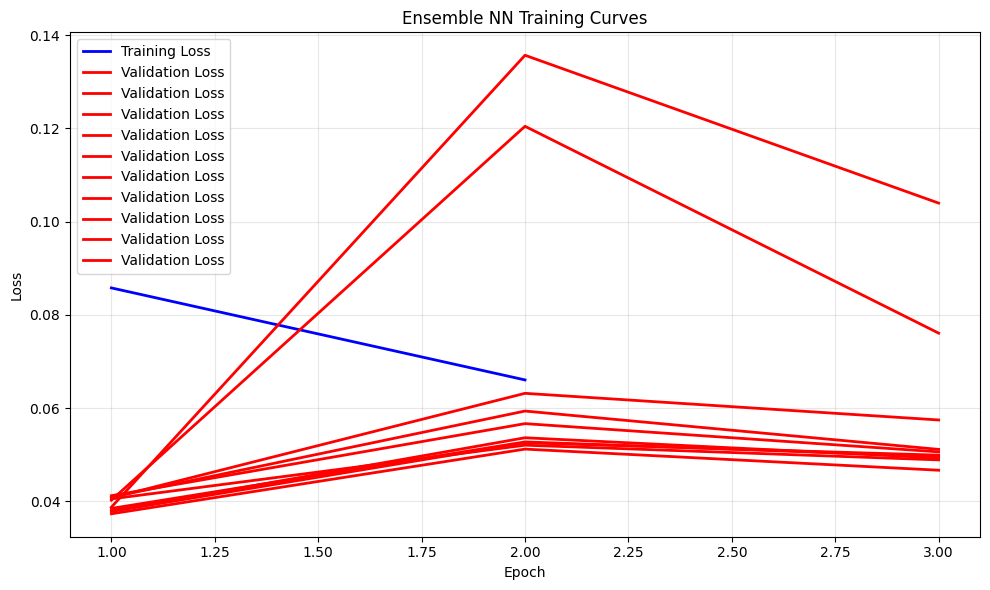

Model 9: Validation loss did NOT improve (first: 0.0380, min: 0.0493)


In [12]:
plot_training_curves(
        ensemble_results['train_losses'][:],#[min(config['ensemble_nn']['patience']-1,5):],
        ensemble_results['val_losses'][:][:],#[min(config['ensemble_nn']['patience']-1,5):],
        title="Ensemble NN Training Curves"
    )
plt.show()

try:
    # check for each val loss if the lowest values is smaller than the first value
    val_losses = ensemble_results['val_losses']
    for i in range(0, config['ensemble_nn']['parallel_models']):
        loss = [ensemble_results['val_losses'][j][i] for j in range(len(ensemble_results['val_losses']))]

    first_loss = loss[0]
    min_loss = min(loss[1:])
    if min_loss < first_loss:
        print(f"Model {i}: Validation loss improved from {first_loss:.4f} to {min_loss:.4f}")
    else:
        print(f"Model {i}: Validation loss did NOT improve (first: {first_loss:.4f}, min: {min_loss:.4f})")
except Exception as e:
    print("Error checking validation losses:")
    traceback.print_exc()

In [13]:
# Initialize Ensemble NN using high-level API
ensemble_nn = EnsembleNNAPI(
    data_list=global_train_data_list,
    target=config['data']['target'],
    quantiles=config['data']['quantiles'],
    forecast_horizons=config['data']['horizons'],
    units_per_layer=config['ensemble_nn']['units_per_layer'],
    lags=config['data']['lags'],
    activation=config['ensemble_nn']['activation'],
    device=config['ensemble_nn']['device'],
    seed=config['seed'], 
    transform=True,  # Enable data transformation
    prefit_AR=True,  # Enable pre-fitting of AR models
    country_ids=country_names,  # Use country names
    time_col="TIME",
    verbose=1, 
    turn_on_neural_net=config['ensemble_nn']['turn_on_neural_net']
)

print(f"✓ Ensemble NN initialized successfully!")
print(f"  Input dimension: {ensemble_nn.input_dim}")
print(f"  Target quantiles: {ensemble_nn.quantiles}")
print(f"  Forecast horizons: {ensemble_nn.forecast_horizons}")

# Load the trained model
print("Loading stored model...")
try:
    ensemble_nn.load_model("stored/EnsembleNN/ALL_")
    print("✓ Model loaded successfully!")
    print(f"  Transformations loaded: {hasattr(ensemble_nn, 'transformations') and len(ensemble_nn.transformations) > 0}")
    if hasattr(ensemble_nn, 'transformations'):
        print(f"  Number of countries with transformations: {len(ensemble_nn.transformations)}")
        sample_country = list(ensemble_nn.transformations.keys())[0] if ensemble_nn.transformations else None
        if sample_country:
            print(f"  Sample country ({sample_country}) has transformations for: {list(ensemble_nn.transformations[sample_country].keys())}")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    import traceback
    traceback.print_exc()

✓ Ensemble NN initialized successfully!
  Input dimension: 1473
  Target quantiles: [0.9]
  Forecast horizons: [1]
Loading stored model...
✓ Model loaded successfully!
  Transformations loaded: True
  Number of countries with transformations: 24
  Sample country (DK) has transformations for: ['ei_bsbu_m_r2_BS-CCI-BAL', 'ei_bsbu_m_r2_BS-CEME-BAL', 'ei_bsbu_m_r2_BS-COB-BAL', 'ei_bsbu_m_r2_BS-CPE-BAL', 'ei_bsbu_m_r2_BS-CTA-BAL', 'ei_bsbu_m_r2_BS-FLBA1-PC', 'ei_bsbu_m_r2_BS-FLBA2-PC', 'ei_bsbu_m_r2_BS-FLBA3-PC', 'ei_bsbu_m_r2_BS-FLBA4-PC', 'ei_bsbu_m_r2_BS-FLBA5-PC', 'ei_bsbu_m_r2_BS-FLBA6-PC', 'ei_bsbu_m_r2_BS-FLBA7-PC', 'ei_bsco_m_BS-CSMCI', 'ei_bsco_m_BS-FS-LY', 'ei_bsco_m_BS-FS-NY', 'ei_bsco_m_BS-GES-LY', 'ei_bsco_m_BS-GES-NY', 'ei_bsco_m_BS-MP-NY', 'ei_bsco_m_BS-MP-PR', 'ei_bsco_m_BS-PT-LY', 'ei_bsco_m_BS-PT-NY', 'ei_bsco_m_BS-SFSH', 'ei_bsco_m_BS-SV-NY', 'ei_bsco_m_BS-UE-NY', 'ei_bsee_m_r2_BS-CEME-BAL', 'ei_bsee_m_r2_BS-EEI-I', 'ei_bsee_m_r2_BS-IEME-BAL', 'ei_bsee_m_r2_BS-REM-BAL', '

In [14]:
# === Train Linear Quantile Regression ===
print("\n" + "="*50)
print("Training Linear Quantile Regression")
print("="*50)

try:
    # Initialize LQR using high-level API
    lqr_model = LQRModel(
        data_list=train_data_list,
        target=config['data']['target'],
        quantiles=config['data']['quantiles'],
        forecast_horizons=config['data']['horizons'],
        lags=config['data']['lags'],
        alpha=1.0,  # Will be cross-validated
        fit_intercept=True,
        solver=config['lqr']['solver'],
        seed=config['seed']
    )
    
    print(f"LQR initialized")
    
    # Cross-validate regularization parameter
    print("Cross-validating regularization parameter...")
    best_alpha = lqr_model.validate_alpha(
        alphas=config['lqr']['alphas'],
        validation_size=config['splits']['validation_size']
    )
    
    print(f"Best alpha: {best_alpha}")
    
    # Fit final model
    print("Fitting final model...")
    lqr_coefficients = lqr_model.fit()
    
    print("LQR training completed!")

    
except Exception as e:
    print(f"LQR training failed: {e}")
    print(f"Error type: {type(e).__name__}")
    print(f"Error location:")
    traceback.print_exc()
    print("This might be due to missing dependencies. Continuing with synthetic model results...")
    lqr_model = None
    lqr_coefficients = None

print("\nModel training phase completed!")


Training Linear Quantile Regression
LQR initialized
Cross-validating regularization parameter...


KeyboardInterrupt: 

In [33]:
### lqr per country
print("\n" + "="*50)
print("LQR Coefficients by Country")
print("="*50)
lqr_models = {}

for i, data in enumerate(train_data_list):
    # Initialize LQR using high-level API
    # if i == 0:
    #     print(data.head())
    lqr_model = LQRModel(
        data_list=[data],
        target=config['data']['target'],
        quantiles=config['data']['quantiles'],
        forecast_horizons=config['data']['horizons'],
        lags=config['data']['lags'],
        alpha=1.0,  # Will be cross-validated
        fit_intercept=True,
        solver=config['lqr']['solver'],
        seed=config['seed']
    )

    
    ##Cross-validate regularization parameter
    best_alpha = lqr_model.k_fold_validation(alphas = config['lqr']['alphas'],
       n_splits=10
    )
    
    print(f"Best alpha for country {countries[i]}: {best_alpha}")
    
    # Fit final model
    lqr_coefficients = lqr_model.fit()
    

    lqr_models[i] = {
        'model': lqr_model,
        'coefficients': lqr_coefficients
    }





    


LQR Coefficients by Country
Best alpha for country DK: 80
Best alpha for country HU: 40
Best alpha for country SE: 80
Best alpha for country IT: 30
Best alpha for country FR: 60
Best alpha for country PT: 50


Optimization did not converge: ABNORMAL: 


Best alpha for country LV: 10
Best alpha for country DE: 60
Best alpha for country EE: 10
Best alpha for country NL: 100
Best alpha for country AT: 20
Best alpha for country EL: 60
Best alpha for country SK: 20
Best alpha for country CZ: 20
Best alpha for country PL: 30
Best alpha for country FI: 50
Best alpha for country LU: 20
Best alpha for country ES: 20
Best alpha for country LT: 20
Best alpha for country MT: 100
Best alpha for country BE: 20
Best alpha for country IE: 40
Best alpha for country SI: 100
Best alpha for country CY: 80


In [34]:
### lqr per country
print("\n" + "="*50)
print("LQR Coefficients by Country")
print("="*50)
lqr_ar_models = {}

for i, data in enumerate(train_data_list):
    # Initialize LQR using high-level API
    if i == 0:
        print(data.head())
    
    # only use the target column and the time column
    data_temp = data[['TIME', config['data']['target']]].copy()

    lqr_model = LQRModel(
        data_list=[data_temp],
        target=config['data']['target'],
        quantiles=config['data']['quantiles'],
        forecast_horizons=config['data']['horizons'],
        lags=config['data']['lags'],
        alpha=0.0,  # Will be cross-validated
        fit_intercept=True,
        solver=config['lqr']['solver'],
        seed=config['seed']
    )

    
    # Cross-validate regularization parameter
    # Cross-validate regularization parameter
    # best_alpha = lqr_model.k_fold_validation(alphas = config['lqr']['alphas'],
    #     n_splits=10
    # )
    
    #print(f"Best alpha for country {i}: {best_alpha}")
    
    # Fit final model


    lqr_coefficients = lqr_model.fit()
    #lqr_model.load_model(f"../stored/{countries[i]}_")
    #lqr_model.store_model(f"../stored/{countries[i]}_")

    lqr_ar_models[i] = {
        'model': lqr_model,
        'coefficients': lqr_coefficients
    }




LQR Coefficients by Country
         TIME  ei_bsbu_m_r2_BS-CCI-BAL  ei_bsbu_m_r2_BS-CEME-BAL  \
51 2004-05-01                 0.297657                  0.215257   
52 2004-06-01                 0.308617                  0.297506   
53 2004-07-01                 0.292177                  0.215257   
54 2004-08-01                 0.396302                  0.256382   
55 2004-09-01                 0.505907                  0.346855   

    ei_bsbu_m_r2_BS-COB-BAL  ei_bsbu_m_r2_BS-CPE-BAL  ei_bsbu_m_r2_BS-CTA-BAL  \
51                 0.327845                 0.351621                 0.327656   
52                 0.296403                 0.175868                 0.294796   
53                 0.319985                 0.319666                 0.215934   
54                 0.449685                 0.255756                 0.117355   
55                 0.559734                 0.255756                 0.340800   

    ei_bsbu_m_r2_BS-FLBA1-PC  ei_bsbu_m_r2_BS-FLBA2-PC  \
51               

In [37]:
lqr_per_country_predictions, lqr_per_country_targets = {}, {}
country_names = [country for country in list(target_train.keys())]
for idx, test_data in enumerate(test_data_list):
    model = lqr_models[idx]['model']
    predictions, targets = model.predict([test_data])
    lqr_per_country_predictions[country_names[idx]] = predictions
    lqr_per_country_targets[country_names[idx]] = targets

lqr_ar_per_country_predictions, lqr_ar_per_country_targets = {}, {}

for idx, test_data in enumerate(test_data_list):
    model = lqr_ar_models[idx]['model']
    predictions, targets = model.predict([test_data[['TIME', config['data']['target']]]])
    lqr_ar_per_country_predictions[country_names[idx]] = predictions
    lqr_ar_per_country_targets[country_names[idx]] = targets

print(f"Number of countries with LQR predictions: {len(lqr_per_country_predictions)}")
print(f"Number of countries with LQR AR predictions: {len(lqr_ar_per_country_predictions)}")

fnn_per_country_predictions, fnn_per_country_targets = {}, {}

for idx, test_data in enumerate(global_test_data_list):

    if config['ensemble_nn']['per_country']:
        model = fnn_models[idx]['model']
        predictions, targets = model.predict_per_country(test_data, "COUNTRY_000", 0)
        fnn_per_country_predictions[country_names[idx]] = predictions
        fnn_per_country_targets[country_names[idx]] = targets
    else:
        if ensemble_nn:
            predictions, targets = ensemble_nn.predict_per_country(test_data, country_names[idx], idx)
  
            fnn_per_country_predictions[country_names[idx]] = predictions
            fnn_per_country_targets[country_names[idx]] = targets
        else:
            fnn_per_country_predictions[country_names[idx]] = None
            fnn_per_country_targets[country_names[idx]] = None

print(f"FNN predictions: {len(fnn_per_country_predictions)} countries")
print(f"LQR predictions: {len(lqr_per_country_predictions)} countries")

# print(lqr_per_country_targets["HUN"][:,0])
# print(fnn_per_country_targets["HUN"][:,0])

# rff_per_country_predictions, rff_per_country_targets = {}, {}

# for idx, test_data in enumerate(test_data_list):
#     model = rff_lqr_models[idx]['model']
#     test_data = add_random_fourier_features(test_data, n_features=config['lqr']['rff_features'], seed=config['seed'])
#     predictions, targets = model.predict([test_data])
#     rff_per_country_predictions[country_names[idx]] = predictions
#     rff_per_country_targets[country_names[idx]] = targets


fnn_per_country_predictions = lqr_ar_per_country_predictions
nn_per_country_targets = lqr_ar_per_country_targets
# lqr_per_country_predictions = lqr_ar_per_country_predictions
# lqr_per_country_targets = lqr_ar_per_country_targets


Number of countries with LQR predictions: 24
Number of countries with LQR AR predictions: 24
FNN predictions: 24 countries
LQR predictions: 24 countries


## 6. Model Evaluation

Now let's evaluate our trained FNN model and make predictions.


FORECAST VISUALIZATION

Creating forecast plots for horizon 1...


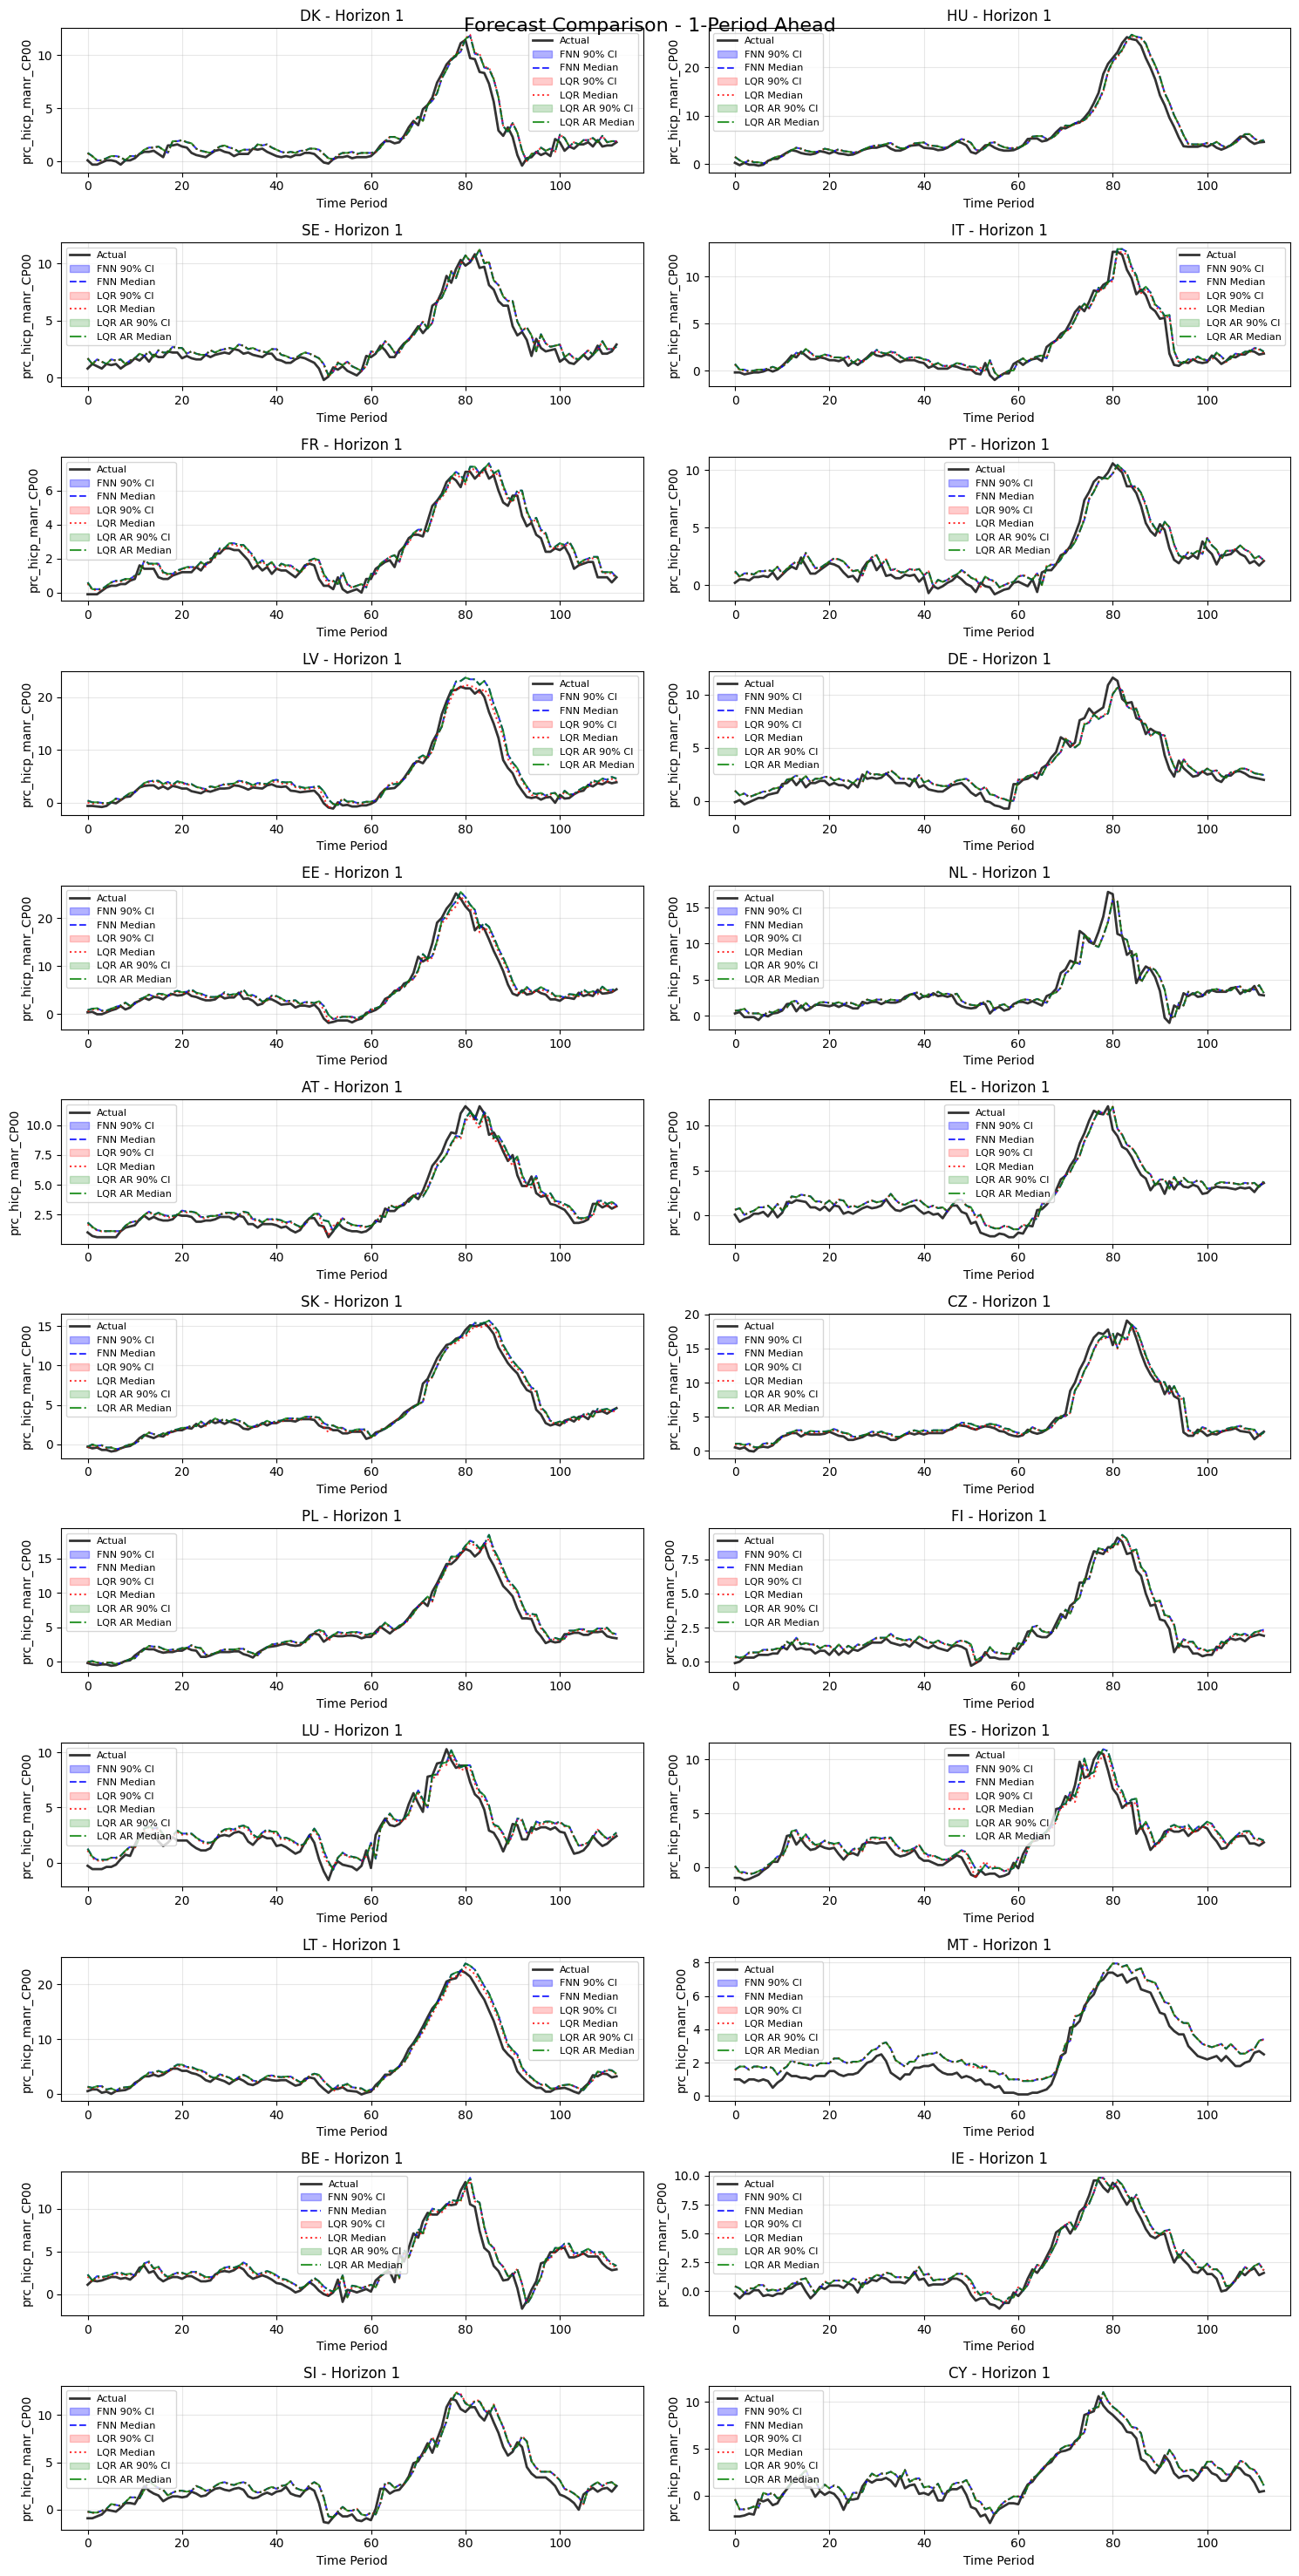

In [38]:
# === 6. Forecast Visualization ===
print("\n" + "="*50)
print("FORECAST VISUALIZATION")
print("="*50)

# Plot forecast paths for each country and horizon
countries = list(scaled_test.keys())
n_countries_to_plot = len(countries)  # Plot first 4 countrie
# divide by 2 and round up for subplots
div_2 = (n_countries_to_plot + 1) // 2


# Calculate country boundaries for indexing into stacked arrays
country_boundaries = [0]
for df in test_data_list:
    country_boundaries.append(country_boundaries[-1] + len(df))

for h, horizon in enumerate(config['data']['horizons']):
    fig, axes = plt.subplots(div_2, 2, figsize=(15, 30))
    axes = axes.flatten()
    
    print(f"\nCreating forecast plots for horizon {horizon}...")
    
    for i, country in enumerate(countries[:n_countries_to_plot]):
        ax = axes[i]
        
        # Get country data boundaries
        start_idx = country_boundaries[i]
        end_idx = country_boundaries[i + 1]
        
        # Extract predictions and targets for this country and horizon
        # Targets: if 2D (samples, horizons), get column h; if 1D, use as-is
        if fnn_per_country_targets[country].ndim == 2:
            actual = fnn_per_country_targets[country][:, h]
        else:
            actual = fnn_per_country_targets[country]  # Single horizon case
        
        # Predictions: (samples, quantiles, horizons) -> get [:, :, h] for this horizon
        fnn_pred_this_horizon = fnn_per_country_predictions[country][:, h]  # (country_samples, quantiles)
        lqr_pred_this_horizon = lqr_per_country_predictions[country][:, h]  # (country_samples, quantiles)
        lqr_ar_pred_this_horizon = lqr_ar_per_country_predictions[country][:, h]  # (country_samples, quantiles)

        # Extract quantiles (assuming first is lower, second is upper)
        try:
            fnn_pred_q05 = fnn_pred_this_horizon[:, 0]  # Lower quantile
            fnn_pred_q95 = fnn_pred_this_horizon[:, 1]  # Upper quantile
            lqr_pred_q05 = lqr_pred_this_horizon[:, 0]
            lqr_pred_q95 = lqr_pred_this_horizon[:, 1]
            lqr_ar_pred_q05 = lqr_ar_pred_this_horizon[:, 0]
            lqr_ar_pred_q95 = lqr_ar_pred_this_horizon[:, 1]
        except IndexError:
            fnn_pred_q05 = [np.nan] * len(actual)
            fnn_pred_q95 = [np.nan] * len(actual)
            lqr_pred_q05 = [np.nan] * len(actual)
            lqr_pred_q95 = [np.nan] * len(actual)
            lqr_ar_pred_q05 = [np.nan] * len(actual)
            lqr_ar_pred_q95 = [np.nan] * len(actual)

            
        # Time index for plotting
        time_idx = range(len(actual))
        
        # Plot actual values
        ax.plot(time_idx, actual, 'k-', linewidth=2, label='Actual', alpha=0.8)
        
        # Plot FNN predictions with uncertainty band
        ax.fill_between(time_idx, fnn_pred_q05, fnn_pred_q95, 
                       alpha=0.3, color='blue', label='FNN 90% CI')
        ax.plot(time_idx, fnn_pred_this_horizon, 'b--', 
               linewidth=1.5, label='FNN Median', alpha=0.8)
        
        # Plot LQR predictions with uncertainty band  
        ax.fill_between(time_idx, lqr_pred_q05, lqr_pred_q95, 
                       alpha=0.2, color='red', label='LQR 90% CI')
        ax.plot(time_idx, lqr_pred_this_horizon, 'r:', 
               linewidth=1.5, label='LQR Median', alpha=0.8)
        
        # Plot LQR AR predictions with uncertainty band
        ax.fill_between(time_idx, lqr_ar_pred_q05, lqr_ar_pred_q95, 
                       alpha=0.2, color='green', label='LQR AR 90% CI')
        ax.plot(time_idx, lqr_ar_pred_this_horizon, 'g-.', 
               linewidth=1.5, label='LQR AR Median', alpha=0.8)
        
        ax.set_title(f'{country} - Horizon {horizon}')
        ax.set_xlabel('Time Period')
        ax.set_ylabel(config['data']['target'])
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Forecast Comparison - {horizon}-Period Ahead', fontsize=16)
    plt.tight_layout()
    plt.show()


In [39]:
# === 8. Statistical Significance Testing ===
print("\n" + "="*50)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*50)

# Generic function for comparing two models
def compare_models_dm_test(model1_predictions, model2_predictions, targets, 
                          model1_name="Model1", model2_name="Model2", countries=None):
    """
    Perform Diebold-Mariano test for forecast accuracy comparison between any two models.
    
    Parameters:
    -----------
    model1_predictions : dict
        Dictionary with country keys and prediction arrays
    model2_predictions : dict  
        Dictionary with country keys and prediction arrays
    targets : dict
        Dictionary with country keys and target arrays
    model1_name : str
        Name of first model for display
    model2_name : str
        Name of second model for display
    countries : list
        List of countries to compare (if None, use all available)
    
    Returns:
    --------
    dict : Results of DM tests per country and aggregate
    """
    from scipy import stats
    
    if countries is None:
        countries = list(model1_predictions.keys())
    
    dm_results_per_country = {}
    dm_results_aggregate = {}

    # Per-Country Diebold-Mariano Tests
    for country in countries:
        if (model1_predictions.get(country) is not None and 
            model2_predictions.get(country) is not None):
            
            dm_results_per_country[country] = {}
            print(f"\n{country} - Diebold-Mariano Tests ({model1_name} vs {model2_name}):")
            
            for h, horizon in enumerate(config['data']['horizons']):
                dm_results_per_country[country][horizon] = {}
                
                for q, quantile in enumerate(config['data']['quantiles']):
                    # Get targets for this country and horizon
                    if targets[country].ndim == 2:
                        actual = targets[country][:, h]
                    else:
                        actual = targets[country]
                    
                    # Get predictions for this country, horizon, and quantile
                    model1_pred = model1_predictions[country][:, h][:, q]
                    model2_pred = model2_predictions[country][:, h][:, q]
                    
                    if len(actual) > 5:  # Need minimum samples for meaningful test
                        # Calculate quantile losses (more appropriate for quantile forecasting)
                        model1_qloss = pinball_loss(actual, model1_pred, quantile)
                        model2_qloss = pinball_loss(actual, model2_pred, quantile)
                        

                        # Diebold-Mariano test statistic
                        # H0: Both forecasts have equal accuracy
                        # H1: Forecasts have different accuracy
                        loss_diff = model1_qloss - model2_qloss  # Positive means Model1 worse
                        
                        # Calculate test statistic
                        mean_diff = np.mean(loss_diff)
                        var_diff = np.var(loss_diff, ddof=1)
                        
                        if var_diff > 0:
                            dm_stat = mean_diff / np.sqrt(var_diff / len(loss_diff))
                            p_value = 2 * (1 - stats.norm.cdf(abs(dm_stat)))  # Two-tailed test
                            
                            dm_results_per_country[country][horizon][quantile] = {
                                'dm_statistic': dm_stat,
                                'p_value': p_value,
                                'significant': p_value < 0.1,
                                'better_model': model2_name if dm_stat > 0 else model1_name
                            }
                            
                            significance = "***" if p_value < 0.01 else "**" if p_value < 0.05 else "*" if p_value < 0.1 else ""
                            
                            print(f"  H{horizon} Q{quantile:.2f}: DM={dm_stat:.3f}, p={p_value:.3f}{significance} -> {dm_results_per_country[country][horizon][quantile]['better_model']}")
                        else:
                            dm_results_per_country[country][horizon][quantile] = {
                                'dm_statistic': 0,
                                'p_value': 1.0,
                                'significant': False,
                                'better_model': 'Tie'
                            }
                            print(f"  H{horizon} Q{quantile:.2f}: No variance in loss differences")
                    else:
                        dm_results_per_country[country][horizon][quantile] = {
                            'dm_statistic': np.nan,
                            'p_value': np.nan,
                            'significant': False,
                            'better_model': 'Insufficient data'
                        }
                        print(f"  H{horizon} Q{quantile:.2f}: Insufficient data for testing")

    return dm_results_per_country, dm_results_aggregate

# Use the generic function to compare FNN vs LQR
dm_results_per_country, dm_results_aggregate = compare_models_dm_test(
    fnn_per_country_predictions, 
    lqr_per_country_predictions, 
    fnn_per_country_targets,
    model1_name="FNN",
    model2_name="LQR",
    countries=countries
)

# Aggregate Diebold-Mariano Tests (for comparison)
def compute_aggregate_dm_tests(model1_predictions, model2_predictions, targets, 
                              model1_name="Model1", model2_name="Model2", countries=None):
    """
    Compute aggregate Diebold-Mariano tests across all countries for any two models.
    """
    from scipy import stats
    
    if countries is None:
        countries = list(model1_predictions.keys())
    
    dm_results_aggregate = {}
    
    print(f"\nAGGREGATE ANALYSIS - Diebold-Mariano Tests ({model1_name} vs {model2_name}):")
    for h, horizon in enumerate(config['data']['horizons']):
        dm_results_aggregate[horizon] = {}
        
        for q, quantile in enumerate(config['data']['quantiles']):
            # Aggregate data across all countries for this horizon and quantile
            all_model1_losses = []
            all_model2_losses = []
            
            for country in countries:
                if (model1_predictions.get(country) is not None and 
                    model2_predictions.get(country) is not None):
                    
                    # Get targets for this country and horizon
                    if targets[country].ndim == 2:
                        actual = targets[country][:, h]
                    else:
                        actual = targets[country]
                    
                    # Get predictions for this country, horizon, and quantile
                    model1_pred = model1_predictions[country][:, h][:, q]
                    model2_pred = model2_predictions[country][:, h][:, q]
                    
                    # Calculate quantile losses
                    model1_qloss = pinball_loss(actual, model1_pred, quantile)
                    model2_qloss = pinball_loss(actual, model2_pred, quantile)
                    
                    all_model1_losses.extend(model1_qloss)
                    all_model2_losses.extend(model2_qloss)
            
            if len(all_model1_losses) > 1:
                # Convert to numpy arrays
                all_model1_losses = np.array(all_model1_losses)
                all_model2_losses = np.array(all_model2_losses)
                
                # Diebold-Mariano test statistic
                loss_diff = all_model1_losses - all_model2_losses  # Positive means Model1 worse
                
                # Calculate test statistic
                mean_diff = np.mean(loss_diff)
                var_diff = np.var(loss_diff, ddof=1)
                
                if var_diff > 0:
                    dm_stat = mean_diff / np.sqrt(var_diff / len(loss_diff))
                    p_value = 2 * (1 - stats.norm.cdf(abs(dm_stat)))  # Two-tailed test
                    
                    dm_results_aggregate[horizon][quantile] = {
                        'dm_statistic': dm_stat,
                        'p_value': p_value,
                        'significant': p_value < 0.1,
                        'better_model': model2_name if dm_stat > 0 else model1_name
                    }
                    
                    significance = "***" if p_value < 0.01 else "**" if p_value < 0.05 else "*" if p_value < 0.1 else ""
                    
                    print(f"  H{horizon} Q{quantile:.2f}: DM={dm_stat:.3f}, p={p_value:.3f}{significance} -> {dm_results_aggregate[horizon][quantile]['better_model']}")
                else:
                    print(f"  H{horizon} Q{quantile:.2f}: No variance in loss differences")
            else:
                print(f"  H{horizon} Q{quantile:.2f}: Insufficient data for testing")
    
    return dm_results_aggregate

# Compute aggregate results for FNN vs LQR
dm_results_aggregate = compute_aggregate_dm_tests(
    fnn_per_country_predictions,
    lqr_per_country_predictions, 
    fnn_per_country_targets,
    model1_name="FNN",
    model2_name="LQR",
    countries=countries
)

# Create Diebold-Mariano summary table
print("\nDiebold-Mariano Test Results Summary:")
dm_summary_data = []

for country in countries:
    if country in dm_results_per_country:
        for horizon in config['data']['horizons']:
            for quantile in config['data']['quantiles']:
                dm_result = dm_results_per_country[country][horizon][quantile]
                dm_summary_data.append({
                    'Country': country,
                    'Horizon': horizon,
                    'Quantile': quantile,
                    'DM_Statistic': dm_result['dm_statistic'],
                    'P_Value': dm_result['p_value'],
                    'Significant': dm_result['significant'],
                    'Better_Model': dm_result['better_model']
                })

dm_summary_df = pd.DataFrame(dm_summary_data)
display(dm_summary_df.round(4))

# === 9. Per-Country Quantile Loss Analysis ===
print("\n9. Computing per-country Quantile Loss metrics...")

# Generic function for per-country metrics comparison
def compute_per_country_metrics(model1_predictions, model2_predictions, targets,
                               model1_name="Model1", model2_name="Model2", countries=None):
    """
    Calculate Quantile Loss for each country, quantile, and horizon for any two models.
    
    Parameters:
    -----------
    model1_predictions : dict
        Dictionary with country keys and prediction arrays
    model2_predictions : dict  
        Dictionary with country keys and prediction arrays
    targets : dict
        Dictionary with country keys and target arrays
    model1_name : str
        Name of first model for display
    model2_name : str
        Name of second model for display
    countries : list
        List of countries to analyze (if None, use all available)
    
    Returns:
    --------
    dict : Per-country metrics for each model
    """
    if countries is None:
        countries = list(model1_predictions.keys())
    
    per_country_metrics = {}

    for country in countries:
        if (model1_predictions.get(country) is not None and 
            model2_predictions.get(country) is not None):
            
            per_country_metrics[country] = {}
            
            for h, horizon in enumerate(config['data']['horizons']):
                per_country_metrics[country][horizon] = {}
                
                # Get targets for this country and horizon
                if targets[country].ndim == 2:
                    actual = targets[country][:, h]
                else:
                    actual = targets[country]
                
                for q, quantile in enumerate(config['data']['quantiles']):
                    per_country_metrics[country][horizon][quantile] = {}
                    
                    # Get predictions for this country, horizon, and quantile
                    model1_pred = model1_predictions[country][:, h][:, q]
                    model2_pred = model2_predictions[country][:, h][:, q]
                    
                    # Calculate Quantile Loss for each model
                    for model_name, pred in [(model1_name, model1_pred), (model2_name, model2_pred)]:
                        q_loss = np.mean(pinball_loss(actual, pred, quantile)[:])
                        per_country_metrics[country][horizon][quantile][model_name] = q_loss
    
    return per_country_metrics

# Calculate metrics for FNN vs LQR
per_country_metrics = compute_per_country_metrics(
    fnn_per_country_predictions,
    lqr_per_country_predictions,
    fnn_per_country_targets,
    model1_name="FNN",
    model2_name="LQR", 
    countries=countries
)

# Create per-country metrics table and aggregate analysis
def create_metrics_comparison_table(per_country_metrics, countries, 
                                   model1_name="Model1", model2_name="Model2"):
    """
    Create comparison tables for any two models and compute aggregate metrics.
    """
    # Create per-country metrics table
    print(f"\nPer-Country Quantile Loss Performance ({model1_name} vs {model2_name}):")
    country_metrics_data = []

    for country in countries:
        if country in per_country_metrics:
            for horizon in config['data']['horizons']:
                for quantile in config['data']['quantiles']:
                    model1_qloss = per_country_metrics[country][horizon][quantile][model1_name]
                    model2_qloss = per_country_metrics[country][horizon][quantile][model2_name]
                    improvement = ((model2_qloss - model1_qloss) / model2_qloss) * 100
                    
                    country_metrics_data.append({
                        'Country': country,
                        'Horizon': horizon,
                        'Quantile': quantile,
                        f'{model1_name}_QLoss': model1_qloss,
                        f'{model2_name}_QLoss': model2_qloss,
                        'Improvement_%': improvement,
                        'Better_Model': model1_name if model1_qloss < model2_qloss else model2_name
                    })

    country_metrics_df = pd.DataFrame(country_metrics_data)
    display(country_metrics_df.round(4))

    # === Aggregate Summary ===
    print(f"\nAggregate Quantile Loss Summary ({model1_name} vs {model2_name}):")
    aggregate_metrics_data = []

    for horizon in config['data']['horizons']:
        for quantile in config['data']['quantiles']:
            # Aggregate across all countries
            all_model1_qloss = []
            all_model2_qloss = []
            
            for country in countries:
                if country in per_country_metrics:
                    all_model1_qloss.append(per_country_metrics[country][horizon][quantile][model1_name])
                    all_model2_qloss.append(per_country_metrics[country][horizon][quantile][model2_name])
            
            avg_model1_qloss = np.mean(all_model1_qloss)
            avg_model2_qloss = np.mean(all_model2_qloss)
            improvement = ((avg_model2_qloss - avg_model1_qloss) / avg_model2_qloss) * 100
            
            aggregate_metrics_data.append({
                'Horizon': horizon,
                'Quantile': quantile,
                f'{model1_name}_QLoss_Avg': avg_model1_qloss,
                f'{model2_name}_QLoss_Avg': avg_model2_qloss,
                'Improvement_%': improvement,
                'Better_Model': model1_name if avg_model1_qloss < avg_model2_qloss else model2_name
            })

    aggregate_df = pd.DataFrame(aggregate_metrics_data)
    print("\nAggregate Performance Across All Countries:")
    display(aggregate_df.round(4))
    
    return country_metrics_df, aggregate_df

# Generate tables for FNN vs LQR comparison
country_metrics_df, aggregate_df = create_metrics_comparison_table(
    per_country_metrics, countries, 
    model1_name="FNN", model2_name="LQR"
)

# === 10. Final Summary and Recommendations ===
print("\n" + "="*60)
print("FINAL QUANTILE LOSS EVALUATION SUMMARY")
print("="*60)

def generate_final_summary(country_metrics_df, per_country_metrics, countries,
                          model1_name="Model1", model2_name="Model2"):
    """
    Generate final summary and recommendations for any two models comparison.
    """
    # Calculate win rates for Quantile Loss only
    qloss_win_summary = {
        f'{model1_name}_wins': 0,
        f'{model2_name}_wins': 0,
        'total_comparisons': len(country_metrics_df)
    }

    for _, row in country_metrics_df.iterrows():
        # Quantile Loss comparison
        if row[f'{model1_name}_QLoss'] < row[f'{model2_name}_QLoss']:
            qloss_win_summary[f'{model1_name}_wins'] += 1
        else:
            qloss_win_summary[f'{model2_name}_wins'] += 1

    print(f"\nQuantile Loss Win Rate Summary ({model1_name} vs {model2_name}):")
    print("-" * 50)
    model1_wins = qloss_win_summary[f'{model1_name}_wins']
    total = qloss_win_summary['total_comparisons']
    model1_rate = (model1_wins / total) * 100

    print(f"Quantile Loss: {model1_name} wins {model1_wins}/{total} ({model1_rate:.1f}%)")

    # Country-by-Country Summary
    print(f"\nCountry-by-Country Performance Summary ({model1_name} vs {model2_name}):")
    print("-" * 60)
    for country in countries:
        if country in per_country_metrics:
            country_data = country_metrics_df[country_metrics_df['Country'] == country]
            country_model1_wins = sum(1 for _, row in country_data.iterrows() if row['Better_Model'] == model1_name)
            country_total = len(country_data)
            country_model1_rate = (country_model1_wins / country_total) * 100 if country_total > 0 else 0
            
            avg_improvement = country_data['Improvement_%'].mean()
            
            print(f"{country}: {model1_name} wins {country_model1_wins}/{country_total} ({country_model1_rate:.1f}%) | "
                  f"Avg improvement: {avg_improvement:+.2f}%")

    # Overall recommendation
    if model1_rate > 60:
        recommendation = f"{model1_name} shows superior quantile forecasting performance"
    elif model1_rate < 40:
        recommendation = f"{model2_name} shows superior quantile forecasting performance"
    else:
        recommendation = f"Both {model1_name} and {model2_name} show comparable quantile forecasting performance"

    print(f"\nOverall Recommendation: {recommendation}")

    # Best and worst performing quantiles and horizons
    print(f"\nPerformance by Quantile and Horizon ({model1_name} vs {model2_name}):")
    print("-" * 50)
    for horizon in config['data']['horizons']:
        print(f"\nHorizon {horizon}:")
        for quantile in config['data']['quantiles']:
            horizon_quantile_data = aggregate_df[
                (aggregate_df['Horizon'] == horizon) & 
                (aggregate_df['Quantile'] == quantile)
            ]
            if not horizon_quantile_data.empty:
                row = horizon_quantile_data.iloc[0]
                print(f"  Quantile {quantile:.2f}: {row['Better_Model']} wins | "
                      f"Improvement: {row['Improvement_%']:+.2f}%")

    print(f"\nKey Insights:")
    print("• Quantile Loss is the most relevant metric for quantile forecasting evaluation")
    print("• Per-country analysis reveals model performance heterogeneity across countries")
    print("• Different quantiles may have varying predictability across forecast horizons")
    print("• Country-specific characteristics may favor different modeling approaches")

    print(f"\n✓ Complete per-country quantile loss evaluation finished ({model1_name} vs {model2_name})!")

# Generate summary for FNN vs LQR
generate_final_summary(country_metrics_df, per_country_metrics, countries,
                      model1_name="FNN", model2_name="LQR")


STATISTICAL SIGNIFICANCE TESTING

DK - Diebold-Mariano Tests (FNN vs LQR):
  H1 Q0.90: DM=2.322, p=0.020** -> LQR

HU - Diebold-Mariano Tests (FNN vs LQR):
  H1 Q0.90: DM=-3.027, p=0.002*** -> FNN

SE - Diebold-Mariano Tests (FNN vs LQR):
  H1 Q0.90: DM=1.589, p=0.112 -> LQR

IT - Diebold-Mariano Tests (FNN vs LQR):
  H1 Q0.90: DM=-1.482, p=0.138 -> FNN

FR - Diebold-Mariano Tests (FNN vs LQR):
  H1 Q0.90: DM=-2.522, p=0.012** -> FNN

PT - Diebold-Mariano Tests (FNN vs LQR):
  H1 Q0.90: DM=1.080, p=0.280 -> LQR

LV - Diebold-Mariano Tests (FNN vs LQR):
  H1 Q0.90: DM=0.804, p=0.421 -> LQR

DE - Diebold-Mariano Tests (FNN vs LQR):
  H1 Q0.90: DM=4.113, p=0.000*** -> LQR

EE - Diebold-Mariano Tests (FNN vs LQR):
  H1 Q0.90: DM=-2.471, p=0.013** -> FNN

NL - Diebold-Mariano Tests (FNN vs LQR):
  H1 Q0.90: DM=3.386, p=0.001*** -> LQR

AT - Diebold-Mariano Tests (FNN vs LQR):
  H1 Q0.90: DM=-1.315, p=0.189 -> FNN

EL - Diebold-Mariano Tests (FNN vs LQR):
  H1 Q0.90: DM=2.794, p=0.005*** ->

,Country,Horizon,Quantile,DM_Statistic,P_Value,Significant,Better_Model
0,DK,1,0.9,2.3221,0.0202,True,LQR
1,HU,1,0.9,-3.0269,0.0025,True,FNN
2,SE,1,0.9,1.5888,0.1121,False,LQR
3,IT,1,0.9,-1.4821,0.1383,False,FNN
4,FR,1,0.9,-2.5218,0.0117,True,FNN
5,PT,1,0.9,1.0801,0.2801,False,LQR
6,LV,1,0.9,0.8044,0.4212,False,LQR
7,DE,1,0.9,4.1127,0.0000,True,LQR
8,EE,1,0.9,-2.4712,0.0135,True,FNN
9,NL,1,0.9,3.3861,0.0007,True,LQR



9. Computing per-country Quantile Loss metrics...

Per-Country Quantile Loss Performance (FNN vs LQR):


,Country,Horizon,Quantile,FNN_QLoss,LQR_QLoss,Improvement_%,Better_Model
0,DK,1,0.9,0.1113,0.1069,-4.1764,LQR
1,HU,1,0.9,0.1981,0.2155,8.0591,FNN
2,SE,1,0.9,0.1182,0.1167,-1.2799,LQR
3,IT,1,0.9,0.1403,0.1456,3.6697,FNN
4,FR,1,0.9,0.0781,0.0864,9.5295,FNN
5,PT,1,0.9,0.1469,0.1443,-1.8170,LQR
6,LV,1,0.9,0.1717,0.1628,-5.4781,LQR
7,DE,1,0.9,0.2073,0.1988,-4.3058,LQR
8,EE,1,0.9,0.2475,0.2865,13.6341,FNN
9,NL,1,0.9,0.2952,0.2919,-1.1331,LQR



Aggregate Quantile Loss Summary (FNN vs LQR):

Aggregate Performance Across All Countries:


,Horizon,Quantile,FNN_QLoss_Avg,LQR_QLoss_Avg,Improvement_%,Better_Model
0,1,0.9,0.1547,0.1618,4.3718,FNN



FINAL QUANTILE LOSS EVALUATION SUMMARY

Quantile Loss Win Rate Summary (FNN vs LQR):
--------------------------------------------------
Quantile Loss: FNN wins 14/24 (58.3%)

Country-by-Country Performance Summary (FNN vs LQR):
------------------------------------------------------------
DK: FNN wins 0/1 (0.0%) | Avg improvement: -4.18%
HU: FNN wins 1/1 (100.0%) | Avg improvement: +8.06%
SE: FNN wins 0/1 (0.0%) | Avg improvement: -1.28%
IT: FNN wins 1/1 (100.0%) | Avg improvement: +3.67%
FR: FNN wins 1/1 (100.0%) | Avg improvement: +9.53%
PT: FNN wins 0/1 (0.0%) | Avg improvement: -1.82%
LV: FNN wins 0/1 (0.0%) | Avg improvement: -5.48%
DE: FNN wins 0/1 (0.0%) | Avg improvement: -4.31%
EE: FNN wins 1/1 (100.0%) | Avg improvement: +13.63%
NL: FNN wins 0/1 (0.0%) | Avg improvement: -1.13%
AT: FNN wins 1/1 (100.0%) | Avg improvement: +5.93%
EL: FNN wins 0/1 (0.0%) | Avg improvement: -2.14%
SK: FNN wins 1/1 (100.0%) | Avg improvement: +16.93%
CZ: FNN wins 1/1 (100.0%) | Avg improvement: +